In [ ]:
import os,sys
import pandas as pd
import scanpy as sc
import scanpy.external as sce
# sc.settings.verbosity = 0
import anndata
import numpy as np
from scipy.sparse import issparse
from sklearn.decomposition import TruncatedSVD
import matplotlib.pylab as plt
%matplotlib inline
from ALLCools.plot import *
from ALLCools.clustering import *
import warnings
warnings.filterwarnings("ignore")
# sc.settings.set_figure_params(dpi=80)
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
from PyComplexHeatmap import *
figdir="figures"
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [ ]:
# Parameters
mc_adata_path = "/home/x-wding2/Projects/BG/adata/BG.gene-CHN.h5ad"
mc_ann_path = "/home/x-wding2/Projects/BG/clustering/100kb/annotations.tsv"
mc_ann_cols = ["Class", "CellClass", "Subclass", "Region"]
rna_ann_cols = ["Neighborhood", "Subclass"]
rna_adata_path = "/home/x-wding2/Projects/BICAN/adata/HMBA_v2/HMBA.Group.downsample_1500.h5ad"
rna_downsample_adata_path = None
outdir = "Subclass_vs_HMBA_Neu.Subclass"
kernel_name = "m3c"
mc_std_cutoff = 0.01
rna_std_cutoff = 0.05
mc_query = "CellClass!='Nonneuron'"
rna_query = "Neighborhood!='Nonneuron'"
mc_cell_type = "Subclass"
rna_cell_type = "Subclass"
rna_gene_symbol_col = None
rna_tsne_key = None
rna_umap_key = "X_umap"
cpu = 16
normalize_rna = False
rna_downsample = 2000
mc_downsample = 2000
mc_palette = "/anvil/projects/x-mcb130189/Wubin/BG/metadata/BG_color_palette.xlsx"
# rna_palette = "/anvil/projects/x-mcb130189/Wubin/BICAN/adata/HMBA_v2/HMBA_color_palette.xlsx"
param_yaml = "/home/x-wding2/Software/conda/m3c/lib/python3.10/site-packages/pym3c/notebooks/integration/HMBA_Neu.yaml"


## Downsample

### snmC-Seq adata

In [97]:
if mc_downsample_adata_path is None:
    mc_downsample_adata_path="m3c.adata"
else:
    mc_downsample_adata_path=os.path.expanduser(mc_downsample_adata_path)
if not os.path.exists(mc_downsample_adata_path):
    adata= anndata.read_h5ad(os.path.expanduser(mc_adata_path),backed='r')
    keep_cells=adata.obs.index.tolist()
    if not mc_ann_path is None:
        if mc_ann_path.endswith('.h5ad'):
            obs=anndata.read_h5ad(os.path.expanduser(mc_ann_path)).obs.copy()
        elif mc_ann_path.endswith('.csv') or mc_ann_path.endswith('.csv.gz'):
            obs=pd.read_csv(os.path.expanduser(mc_ann_path),index_col=0)
        else:
            obs=pd.read_csv(os.path.expanduser(mc_ann_path),index_col=0,sep='\t')
        # adata.obs=obs.reindex(index=adata.obs_names).copy()
        keep_cells=list(set(keep_cells) & set(obs.index.tolist()))
        if mc_ann_cols is None:
            mc_ann_cols=[]
        for col in obs.columns.tolist():
            if col not in mc_ann_cols+[mc_cell_type]:
                continue
            adata.obs[col]=adata.obs_names.map(obs[col].to_dict())
    if not level is None and mc_cell_type=='cluster_id' and mc_cell_type in adata.obs.columns.tolist():
        # too many clusters for cluster_id, use the first two level (such as  c5+c20+c0 -> c5+c20)
        adata.obs[mc_cell_type]=adata.obs['cluster_id'].apply(lambda x:"+".join(x.split('+')[:level]) if not pd.isna(x) else x)
    # only keep the cell types with at least 50 cells
    adata.obs[mc_cell_type]=adata.obs[mc_cell_type].astype('category')
    vc=adata.obs[mc_cell_type].value_counts()
    keep_cts=vc[vc>=min_cell].index.tolist()
    cells=adata.obs.loc[adata.obs[mc_cell_type].isin(keep_cts)].index.tolist()
    keep_cells=list(set(keep_cells) & set(cells))
    if mc_downsample and adata.n_obs > mc_downsample:
        # downsample to 500 cells per major type
        if not mc_query is None:
            use_cells=adata.obs.loc[adata.obs[mc_cell_type].notna()].query(mc_query).groupby(mc_cell_type).apply(lambda x:x.sample(mc_downsample).index.tolist() if x.shape[0] > mc_downsample else x.index.tolist()).sum()
        else:
            use_cells=adata.obs.loc[adata.obs[mc_cell_type].notna()].groupby(mc_cell_type).apply(lambda x:x.sample(mc_downsample).index.tolist() if x.shape[0] > mc_downsample else x.index.tolist()).sum()
        keep_cells=list(set(keep_cells) & set(use_cells))
    elif not mc_query is None:
        use_cells=adata.obs.loc[adata.obs[mc_cell_type].notna()].query(mc_query).index.tolist()
        keep_cells=list(set(keep_cells) & set(use_cells))
    mc_adata=adata[keep_cells,:].to_memory()
    # adata.obs[mc_cell_type]=pd.Categorical(adata.obs[mc_cell_type])
    mc_adata.obs[mc_cell_type]=mc_adata.obs[mc_cell_type].astype('category')
    sc.tl.rank_genes_groups(mc_adata,groupby=mc_cell_type,method="wilcoxon")
    adata.file.close()
    print(adata.shape)
    mc_adata.strings_to_categoricals()
    mc_adata.write_h5ad(mc_downsample_adata_path)
else:
    mc_adata=anndata.read_h5ad(mc_downsample_adata_path)
if normalize_per_cell:  # divide frac by prior mean (determined by alpha and beta) for each cell
    cols = mc_adata.obs.columns.tolist()
    if 'prior_mean' in cols:
        print("Normalizing cell level fraction by alpha and beta (prior_mean)")
        mc_adata.X = mc_adata.X / mc_adata.obs.prior_mean.values[:, None]
mc_adata

Normalizing cell level fraction by alpha and beta (prior_mean)


AnnData object with n_obs × n_vars = 27294 × 37979
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'Region', 'CellClass', 'Subclass', 'Class'
    uns: 'leiden', 'log', 'neighbors', 'normalize_per_cell', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_tsne_raw', 'X_umap'

AnnData object with n_obs × n_vars = 27294 × 37979
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'Region', 'CellClass', 'Subclass', 'Class'
    uns: 'leiden', 'log', 'neighbors', 'normalize_per_cell', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_tsne_raw', 'X_umap'

In [5]:
# sc.pl.rank_genes_groups_dotplot(
#     mc_adata, groupby=mc_cell_type, standard_scale="var", n_genes=-3,cmap='bwr',
#     values_to_plot='scores'
# )

### sc-RNA-seq dataset

In [98]:
if rna_downsample_adata_path is None:
    rna_downsample_adata_path="rna.adata"
else:
    rna_downsample_adata_path=os.path.expanduser(rna_downsample_adata_path)
if not os.path.exists(rna_downsample_adata_path):
    adata = anndata.read_h5ad(os.path.expanduser(rna_adata_path),backed='r')
    if not rna_ann_path is None:
        if rna_ann_path.endswith('.h5ad'):
            obs=anndata.read_h5ad(os.path.expanduser(rna_ann_path)).obs.copy()
        elif rna_ann_path.endswith('.csv') or rna_ann_path.endswith('.csv.gz'):
            obs=pd.read_csv(rna_ann_path,index_col=0)
        else:
            obs=pd.read_csv(rna_ann_path,index_col=0,sep='\t')
        if not rna_ann_cols is None:
            for col in obs.columns.tolist():
                if col not in rna_ann_cols+[rna_cell_type]:
                    continue
                adata.obs[col]=adata.obs_names.map(obs[col].to_dict())
        # adata.obs=obs.reindex(index=adata.obs_names).copy()
    if rna_cell_type==mc_cell_type:
        new_rna_cell_type=f'RNA.{rna_cell_type}'
        adata.obs.rename(columns={rna_cell_type:new_rna_cell_type},inplace=True)
        rna_cell_type=new_rna_cell_type
    # only keep the cell types with at least 50 cells
    adata.obs[rna_cell_type]=adata.obs[rna_cell_type].astype('category')
    vc=adata.obs[rna_cell_type].value_counts()
    keep_cts=vc[vc>=min_cell].index.tolist()
    keep_cells=adata.obs.loc[adata.obs[rna_cell_type].isin(keep_cts)].index.tolist()
    print(adata.shape)
    if rna_downsample and adata.n_obs > rna_downsample:
        if rna_query is None:
            use_cells=adata.obs.loc[adata.obs[rna_cell_type].notna()].groupby(rna_cell_type).apply(lambda x:x.sample(rna_downsample).index.tolist() if x.shape[0] > rna_downsample else x.index.tolist()).sum()
        else:
            use_cells=adata.obs.loc[adata.obs[rna_cell_type].notna()].query(rna_query).groupby(rna_cell_type).apply(lambda x:x.sample(rna_downsample).index.tolist() if x.shape[0] > rna_downsample else x.index.tolist()).sum()
        use_obs=adata.obs_names.isin(list(set(keep_cells) & set(use_cells)))
        rna_adata=adata[use_obs].to_memory()
    else:
        if rna_query is None:
            rna_adata=adata[keep_cells].to_memory()
        else:
            use_cells=adata.obs.loc[adata.obs[rna_cell_type].notna()].query(rna_query).index.tolist()
            use_obs=adata.obs_names.isin(list(set(keep_cells) & set(use_cells)))
            rna_adata=adata[use_obs].to_memory()
    adata.obs[rna_cell_type]=pd.Categorical(adata.obs[rna_cell_type])
    if not rna_gene_symbol_col is None:
        # handle duplicated gene symbols: groupby and get mean
        gdf=rna_adata.to_df().T #columns are cells and index are gene_ids
        geneid2name=adata.var[rna_gene_symbol_col].to_dict()
        gdf['gene_name'] = gdf.index.to_series().map(geneid2name)
        gene_vc = gdf.gene_name.value_counts()
        dup_genes = gene_vc.loc[gene_vc >= 2].index.tolist()
        gdf1 = gdf.loc[gdf.gene_name.isin(dup_genes)] #columns are cells, row are genes
        gdf.drop(gdf1.index.tolist(), inplace=True) # drop rows, columns (cells) unchanged
        gdf.set_index('gene_name', inplace=True)
        gdf1 = gdf1.groupby('gene_name').sum()
        gdf = gdf.T
        gdf1 = gdf1.T
        assert gdf.index.tolist() == gdf1.index.tolist()
        for gene in gdf1:
            gdf[gene] = gdf1[gene].tolist()
        del gdf1
        rna_adata = anndata.AnnData(X=gdf, dtype='float32')
        rna_adata.obs=adata.obs.loc[rna_adata.obs_names].copy()

    rna_adata.raw=rna_adata.copy()
    if not rna_tsne_key is None and rna_tsne_key!='X_tsne':
        rna_adata.obsm['X_tsne']=adata[rna_adata.obs_names,].obsm[rna_tsne_key]
    if not rna_umap_key is None and rna_umap_key != 'X_umap':
        rna_adata.obsm['X_umap']=adata[rna_adata.obs_names,].obsm[rna_umap_key]
    
    # Normalization
    if rna_adata.X.dtype != 'float32':
        rna_adata.X = rna_adata.X.astype('float32')
    if normalize_rna:
        sc.pp.filter_genes(rna_adata,min_cells=5)
        sc.pp.normalize_total(rna_adata, target_sum=1e4)
        sc.pp.log1p(rna_adata)
    if rna_embedding:
        sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
        sc.tl.pca(rna_adata)
        sc.pl.pca_variance_ratio(rna_adata, n_pcs=50) #log=True
        # sce.pp.harmony_integrate(adata, key='donor',
        #                          basis='X_pca', max_iter_harmony=50)
        use_rep = 'X_pca' #'X_pca_harmony'
        sc.pp.neighbors(rna_adata,use_rep=use_rep)
        sc.tl.umap(rna_adata)
        rna_umap_key="X_umap"
    if issparse(rna_adata.X):
        rna_adata.X = rna_adata.X.toarray()
    if not rna_std_cutoff is None:
        std_filter = rna_adata.X.std(axis=0) > rna_std_cutoff
        rna_adata._inplace_subset_var(std_filter)
    sc.tl.rank_genes_groups(rna_adata,groupby=rna_cell_type,method="wilcoxon",use_raw=False)
    adata.file.close()
    rna_adata.strings_to_categoricals()
    rna_adata.write_h5ad(rna_downsample_adata_path)
else:
    rna_adata=anndata.read_h5ad(rna_downsample_adata_path)
rna_adata

AnnData object with n_obs × n_vars = 34555 × 33074
    obs: 'Neighborhood', 'Class', 'RNA.Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'atac_confidently_mapped_read_pairs', 'atac_fraction_of_genome_in_peaks', 'atac_fraction_of_high_quality_fragments_in_cells', 'atac_fraction_of_high_quality_fragments_overlapping_tss', 'atac_fraction_of_high_quality_fragments_overlapping_peaks', 'atac_fraction_of_transposition_events_in_peaks_in_cells', 'atac_mean_raw_read_pairs_per_cell', 'atac_median_high_quality_fragments_per_cell', 'a

In [7]:
# if use_genes is None:
#     sc.pl.rank_genes_groups_dotplot(
#         rna_adata, groupby=rna_cell_type, standard_scale="var", n_genes=3,cmap='bwr',
#         values_to_plot='scores'
#     )

## View

In [99]:
if rna_cell_type==mc_cell_type:
    new_rna_cell_type=f'RNA.{rna_cell_type}'
    rna_adata.obs.rename(columns={rna_cell_type:new_rna_cell_type},inplace=True)
    rna_cell_type=new_rna_cell_type

In [ ]:
rna_colors=None
if not rna_tsne_key is None:
    with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
        plt.figure()
        sc.pl.tsne(rna_adata,color=[rna_cell_type],
                   cmap='jet',ncols=2,wspace=0.25,show=False,vmin='p5',vmax='p95')
        # plt.savefig(os.path.join("figures","MajorType.tsne.summary.pdf"),bbox_inches='tight',dpi=300)
        plt.show()
if not rna_umap_key is None:
    with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
        plt.figure()
        sc.pl.umap(rna_adata,color=[rna_cell_type],cmap='jet',
               ncols=2,wspace=0.25,show=False,vmin='p5',vmax='p95')
        plt.show()
    rna_colors={cluster:color for cluster,color in zip(rna_adata.obs[rna_cell_type].cat.categories.tolist(),rna_adata.uns[f'{rna_cell_type}_colors'])}
rna_adata.obs[rna_cell_type].value_counts()

In [ ]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    plt.figure()
    sc.pl.tsne(mc_adata,color=[mc_cell_type],
               cmap='jet',ncols=2,wspace=0.25,show=False,vmin='p5',vmax='p95')
    # plt.savefig(os.path.join("figures","MajorType.tsne.summary.pdf"),bbox_inches='tight',dpi=300)
    plt.show()
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    plt.figure()
    sc.pl.umap(mc_adata,color=[mc_cell_type],cmap='jet',
           ncols=2,wspace=0.25,show=False,vmin='p5',vmax='p95')
    plt.show()
mc_colors={cluster:color for cluster,color in zip(mc_adata.obs[mc_cell_type].cat.categories.tolist(),mc_adata.uns[f'{mc_cell_type}_colors'])}
mc_adata.obs[mc_cell_type].value_counts()

## Feature Selection

### Methylation

In [10]:
if use_genes is None:
    # use top 200 DEGs and DMGs for each cell type group and use the union of two gene sets as features for integration
    markers = sc.get.rank_genes_groups_df(mc_adata, group=mc_adata.obs[mc_cell_type].unique())
    markers=markers.loc[~ markers.names.isna()]
    markers=markers.loc[(~ markers.logfoldchanges.isna()) & (markers.scores < 0) & (markers.pvals < 0.05)]
    markers.sort_values('logfoldchanges',ascending=True,inplace=True)
    mc_features= markers.groupby('group').apply(lambda x:x.head(topn).names.tolist()).sum()
    print(len(mc_features),mc_features[:10])
    markers

4600 ['MEIS2', 'ENSG00000282943', 'ENSG00000279072', 'TSHZ1', 'PSG2', 'WNT7A', 'IGSF23', 'PSG8', 'PSG11', 'CSF1']


### RNA

In [11]:
if use_genes is None:
    markers = sc.get.rank_genes_groups_df(rna_adata, group=rna_adata.obs[rna_cell_type].unique())
    markers=markers.loc[~ markers.names.isna()]
    markers=markers.loc[(~ markers.logfoldchanges.isna()) & (markers.scores > 0) & (markers.pvals < 0.05)]
    markers.sort_values('logfoldchanges',ascending=False,inplace=True)
    rna_features= markers.groupby('group').apply(lambda x:x.head(topn).names.tolist()).sum()
    print(len(rna_features),rna_features[:10])
    markers

4600 ['AC109466.1', 'GPR6', 'DRD2', 'AC008415.1', 'AC107208.1', 'CCDC88C', 'MEIS2', 'ANO3', 'PENK', 'ADAMTS3']


In [12]:
if use_genes is None:
    selected_features=list(set(mc_features+rna_features))
else:
    if isinstance(use_genes,list):
        selected_features=use_genes
    else:
        print(use_genes)
        selected_features=pd.read_csv(os.path.expanduser(use_genes),index_col=0,sep='\t',header=None).index.tolist()
print(len(selected_features),selected_features[:10])

4492 ['CDH11', 'ETS1', 'AL161908.1', 'ASB5', 'SALL1', 'CHRD', 'AL139379.1', 'VIPR2', 'USP9X', 'AC093627.22']


In [13]:
mc_adata._inplace_subset_var(mc_adata.var_names.isin(selected_features))
rna_adata._inplace_subset_var(rna_adata.var_names.isin(selected_features))

## Filter & Normalization

In [14]:
if not mc_std_cutoff is None:
    std_filter = mc_adata.X.std(axis=0) > mc_std_cutoff
    mc_adata._inplace_subset_var(std_filter)
mc_adata

AnnData object with n_obs × n_vars = 27294 × 3825
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'Region', 'CellClass', 'Subclass', 'Class'
    uns: 'leiden', 'log', 'neighbors', 'normalize_per_cell', 'umap', 'rank_genes_groups', 'Subclass_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_tsne_raw', 'X_umap'

In [15]:
# Normalize mc adata
# log mC fraction and scale features
log_scale(mc_adata, with_mean=True) ## after log: 0-0.69, after scale: z score (columns)
# reverse mC fraction so its positively corr with RNA
mc_adata.X *= -1
mc_adata

AnnData object with n_obs × n_vars = 27294 × 3825
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'Region', 'CellClass', 'Subclass', 'Class'
    uns: 'leiden', 'log', 'neighbors', 'normalize_per_cell', 'umap', 'rank_genes_groups', 'Subclass_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_tsne_raw', 'X_umap'

In [16]:
sc.pp.scale(rna_adata, zero_center=True) # z score by columns (genes)

In [17]:
use_vars = list(set(rna_adata.var_names.unique().tolist()).intersection(
    set(mc_adata.var_names.tolist())))
print(len(use_vars),use_vars[:10])

3108 ['ETS1', 'CDH11', 'ASB5', 'SALL1', 'CHRD', 'VIPR2', 'TNFAIP8', 'USP9X', 'CAPN13', 'EYA4']


In [18]:
mc_adata=mc_adata[:,use_vars]
rna_adata=rna_adata[:,use_vars]

In [19]:
mc_adata

View of AnnData object with n_obs × n_vars = 27294 × 3108
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'Region', 'CellClass', 'Subclass', 'Class'
    uns: 'leiden', 'log', 'neighbors', 'normalize_per_cell', 'umap', 'rank_genes_groups', 'Subclass_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_tsne_raw', 'X_umap'

In [20]:
rna_adata

View of AnnData object with n_obs × n_vars = 34555 × 3108
    obs: 'Neighborhood', 'Class', 'RNA.Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'atac_confidently_mapped_read_pairs', 'atac_fraction_of_genome_in_peaks', 'atac_fraction_of_high_quality_fragments_in_cells', 'atac_fraction_of_high_quality_fragments_overlapping_tss', 'atac_fraction_of_high_quality_fragments_overlapping_peaks', 'atac_fraction_of_transposition_events_in_peaks_in_cells', 'atac_mean_raw_read_pairs_per_cell', 'atac_median_high_quality_fragments_per_ce

In [21]:
# mc_adata.write("m3c.fea_selected.adata")
# rna_adata.write("rna.fea_selected.adata")

## Merge & PCA

In [22]:
# mc_adata=anndata.read_h5ad("m3c.fea_selected.adata")
# rna_adata=anndata.read_h5ad("rna.fea_selected.adata")

In [23]:
ref_adata=rna_adata
query_adata=mc_adata
batch_categories=["RNA", "mC"]

In [24]:
adata = ref_adata.concatenate(
    query_adata, batch_categories=batch_categories, batch_key="Modality", index_unique=None
)
print(adata.obs.Modality.value_counts())
adata

Modality
RNA    34555
mC     27294
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 61849 × 3108
    obs: 'Neighborhood', 'Class', 'RNA.Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'atac_confidently_mapped_read_pairs', 'atac_fraction_of_genome_in_peaks', 'atac_fraction_of_high_quality_fragments_in_cells', 'atac_fraction_of_high_quality_fragments_overlapping_tss', 'atac_fraction_of_high_quality_fragments_overlapping_peaks', 'atac_fraction_of_transposition_events_in_peaks_in_cells', 'atac_mean_raw_read_pairs_per_cell', 'atac_median_high_quality_fragments_per_cell', 'at

In [25]:
np.random.seed(0)

# select ref cells to fit the model
train_cell = np.zeros(ref_adata.shape[0], dtype=bool)
if ref_adata.shape[0] > n_train_cell:
    train_cell[
        np.random.choice(np.arange(ref_adata.shape[0]), n_train_cell, False)
    ] = True
else:
    train_cell[:] = True

ref_adata.obs["Train"] = train_cell.copy()

In [26]:
## Run PCA on Merged Adata
n_feature = ref_adata.shape[1]
if n_feature >= 100:
    model = TruncatedSVD(n_components=100, random_state=0, algorithm='randomized')
else:
    model = TruncatedSVD(n_components=n_feature - 1, random_state=0, algorithm='randomized')

# use selected train cells to fit
model.fit(ref_adata.X[ref_adata.obs["Train"].values])
sel_dim = model.singular_values_ != 0
print(sel_dim.sum(), 'non-zero singular values')

100 non-zero singular values


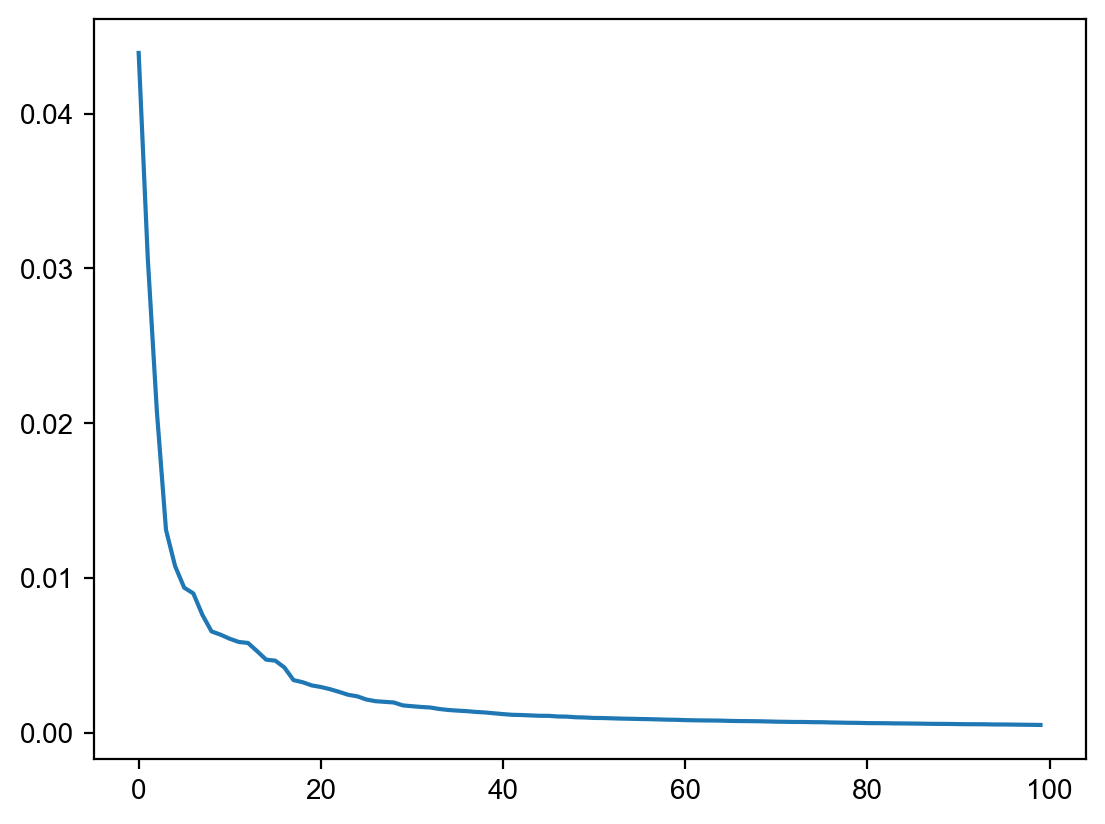

In [27]:
fig, ax = plt.subplots()
ax.plot(model.explained_variance_ratio_)

In [28]:
# transform all other data
chunks = []
for chunk_start in range(0, adata.shape[0], chunk_size):
    chunks.append(
        model.transform(adata.X[chunk_start : (chunk_start + chunk_size)])
    )

# add NNZ PCs to adata
adata.obsm["X_pca"] = np.concatenate(chunks, axis=0)[:, sel_dim]

# remove low variance PCs
n_pcs = significant_pc_test(adata, p_cutoff=0.05, obsm="X_pca")

# scale PC by singular values
adata.obsm["X_pca"] /= model.singular_values_[sel_dim][:n_pcs]

Downsample PC matrix to 50000 cells to calculate significant PC components


29 components passed P cutoff of 0.05.
Changing adata.obsm[X_pca] from shape (61849, 100) to (61849, 29)


In [29]:
for col in adata.obs.select_dtypes(['category', 'object']).columns:
    adata.obs[col] = adata.obs[col].astype(str)
for m in batch_categories:
    adata1 = adata[adata.obs["Modality"] == m]
    cols=adata1.obs.columns.tolist()
    for col in cols:
        if adata1.obs[col].notna().sum() == 0:
            adata1.obs.drop(col,axis=1,inplace=True) #otherwise, would get error:Can't implicitly convert non-string objects to strings for all nan columns
    adata1.strings_to_categoricals()
    adata1.write_h5ad(f"{m.lower()}_pca.h5ad")

## Seurat Integration

In [30]:
ref_adata = anndata.read_h5ad("rna_pca.h5ad")
query_adata = anndata.read_h5ad("mc_pca.h5ad")

In [31]:
adata_list = [ref_adata, query_adata]

In [32]:
for adata in adata_list:
    print(adata.shape)

(34555, 3108)
(27294, 3108)


### Init empty adata_merge

In [33]:
from scipy.sparse import csr_matrix

cells = sum([a.shape[0] for a in adata_list])
features = adata_list[0].shape[1]

adata_merge = anndata.AnnData(
    X=csr_matrix((cells, features), dtype=np.float32),
    obs=pd.concat([a.obs for a in adata_list]),
    var=adata_list[0].var,
)

In [34]:
adata_list[0].obsm["X_pca"].shape,adata_list[1].obsm["X_pca"].shape

((34555, 29), (27294, 29))

In [35]:
n_pc = adata_list[0].obsm["X_pca"].shape[1]
if n_pc < 10:
    n_cca_components = n_pc
else:
    n_cca_components = max(n_pc - 10, 10)

n_cca_components

19

In [36]:
min_sample = adata_merge.obs["Modality"].value_counts().min()
min_sample

27294

### Integration and transform

In [37]:
from ALLCools.clustering import *
from ALLCools.integration.seurat_class import SeuratIntegration
from ALLCools.plot import *

In [38]:
integrator = SeuratIntegration()

In [39]:
# take ~2.5-3h for 300K mC + 4M 10X RNA
anchor = integrator.find_anchor(
    adata_list,
    k_local=None,
    key_local="X_pca",
    k_anchor=5,
    key_anchor="X",
    dim_red="cca",
    max_cc_cells=100000,
    k_score=30,
    k_filter=min(200, min_sample),
    scale1=True,
    scale2=True,
    n_components=n_cca_components,
    n_features=200,
    alignments=None,#[[[0], [1]]],
)

Find anchors across datasets.


Run CCA


non zero dims 19


Find Anchors using k=30


Anchor selected with high CC feature graph: 10991 / 28847
Score Anchors
Identified 10991 anchors between datasets 0 and 1.


In [40]:
corrected = integrator.integrate(
    key_correct="X_pca",
    row_normalize=True,
    k_weight=100,
    sd=1,
    alignments=None, #[[[0], [1]]],
)

adata_merge.obsm["X_pca_integrate"] = np.concatenate(corrected)

Alignments: [[[0], [1]]]
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. 

k_weight:  100


Normalize graph
Transform data


### Label transfer

In [41]:
if key_to_transfer is None:
    key_to_transfer=[rna_cell_type]
key_to_transfer

['RNA.Subclass']

In [42]:
label_transfer=integrator.label_transfer(
    ref=[0],qry=[1],categorical_key=key_to_transfer,continuous_key=None,
    key_dist='X_pca',
)
adata_merge.uns['label_transfer']=label_transfer
for key in label_transfer:
    labels = label_transfer[key].columns.tolist()
    adata_merge.obs[f'infer_{key}'] = adata_merge.obs.index.to_series().map(
        label_transfer[key].apply(lambda x: labels[np.argmax(x)], axis=1).to_dict())
    adata_merge.obs[f'infer_{key}_prob'] = adata_merge.obs.index.to_series().map(
        label_transfer[key].apply(lambda x: x[np.argmax(x)], axis=1).to_dict())
    adata_merge.obs[key] = adata_merge.obs.apply(
        lambda x: x[key] if not pd.isna(x[key]) else x[f'infer_{key}'], axis=1)

Initialize
Find nearest anchors. 

k_weight:  100


Normalize graph
Label transfer


In [43]:
# adata=adata_merge[adata_merge.obs['Modality'] == 'mC']
# for key in key_to_transfer:
#     with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):    
#         sc.pl.tsne(adata, color=[f'infer_{key}',f'infer_{key}_prob'], 
#                    wspace=0.8)
#         sc.pl.umap(adata, color=[f'infer_{key}',f'infer_{key}_prob'], 
#                    wspace=0.8)

### Harmony for embedding

In [44]:
sce.pp.harmony_integrate(adata_merge,
                     key='Modality',basis='X_pca_integrate',
                     nclust=50,max_iter_harmony=30) #X_pca_harmony

2025-07-06 15:13:11,510 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-07-06 15:13:14,979 - harmonypy - INFO - sklearn.KMeans initialization complete.


2025-07-06 15:13:15,110 - harmonypy - INFO - Iteration 1 of 30


2025-07-06 15:13:20,387 - harmonypy - INFO - Iteration 2 of 30


2025-07-06 15:13:25,067 - harmonypy - INFO - Iteration 3 of 30


2025-07-06 15:13:26,787 - harmonypy - INFO - Iteration 4 of 30


2025-07-06 15:13:28,752 - harmonypy - INFO - Iteration 5 of 30


2025-07-06 15:13:30,723 - harmonypy - INFO - Converged after 5 iterations


### TSNE

In [45]:
# 1 hour to run 4M + 3K cell
tsne(adata_merge, obsm='X_pca_harmony',n_jobs=cpu)

### UMAP

In [46]:
# 15 min to run 4M + 3K cell
sc.pp.neighbors(adata_merge, use_rep='X_pca_harmony')

In [47]:
# 2 hours to run 4M + 3K cell
print(resolution)
sc.tl.leiden(adata_merge, resolution=resolution)

2.5


In [48]:
# 2 hours to run 4M + 3K cell
# 4 hours to run 4M + 3K cell if using spectral init, the init step is very slow
min_dist = max(0.1, 1 - adata_merge.shape[0] / 60000)
try:
    sc.tl.paga(adata_merge, groups=rna_cell_type) #leiden
    sc.pl.paga(adata_merge, plot=False)
    sc.tl.umap(adata_merge, min_dist=min_dist, init_pos='paga')
except Exception:
    print('Init with PAGA failed, use default spectral init')
    sc.tl.umap(adata_merge, min_dist=min_dist)

In [49]:
adata_merge.write_h5ad("final.h5ad")

## Plot

In [101]:
adata_merge = anndata.read_h5ad('final.h5ad')
adata_merge

AnnData object with n_obs × n_vars = 61849 × 3108
    obs: 'Neighborhood', 'Class', 'RNA.Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'atac_confidently_mapped_read_pairs', 'atac_fraction_of_genome_in_peaks', 'atac_fraction_of_high_quality_fragments_in_cells', 'atac_fraction_of_high_quality_fragments_overlapping_tss', 'atac_fraction_of_high_quality_fragments_overlapping_peaks', 'atac_fraction_of_transposition_events_in_peaks_in_cells', 'atac_mean_raw_read_pairs_per_cell', 'atac_median_high_quality_fragments_per_cell', 'at

In [ ]:
mc_vc=adata_merge.obs.query("Modality=='mC'").groupby('leiden')[mc_cell_type].value_counts(normalize=True).sort_values(ascending=False).reset_index()
rna_vc=adata_merge.obs.query("Modality=='RNA'").groupby('leiden')[rna_cell_type].value_counts(normalize=True).sort_values(ascending=False).reset_index()
# mc_vc=mc_vc.loc[mc_vc.proportion > 0.5]
# rna_vc=rna_vc.loc[rna_vc.proportion > 0.5]
mc_vc.drop_duplicates('leiden',keep='first',inplace=True)
rna_vc.drop_duplicates('leiden',keep='first',inplace=True)
mc_vc.rename(columns={'proportion':f'{mc_cell_type}_proportion'},inplace=True)
rna_vc.rename(columns={'proportion':f'{rna_cell_type}_proportion'},inplace=True)
df_map=pd.concat([mc_vc.set_index('leiden'),rna_vc.set_index('leiden')],axis=1)
df_map[f'{mc_cell_type}_cell_count']=df_map.index.to_series().map(adata_merge.obs.query("Modality=='mC'").groupby('leiden')[mc_cell_type].count()).astype(int)
df_map[f'{rna_cell_type}_cell_count']=df_map.index.to_series().map(adata_merge.obs.query("Modality=='RNA'").groupby('leiden')[rna_cell_type].count()).astype(int)
df_map.to_csv("cell_types_mapping.tsv",sep='\t')
df_map.query(f"`{mc_cell_type}_cell_count` > 100 & `{rna_cell_type}_cell_count` > 100")

In [103]:
print(adata_merge.obs['Modality'].unique())

['RNA', 'mC']
Categories (2, object): ['RNA', 'mC']


In [104]:
hue_cols=[mc_cell_type,rna_cell_type]
modalities=['mC','RNA']

In [105]:
if not mc_palette is None:
    if os.path.isfile(os.path.expanduser(mc_palette)) and os.path.exists(os.path.expanduser(mc_palette)): #excel
        D=pd.read_excel(os.path.expanduser(mc_palette),
                    sheet_name=None, index_col=0)
        mc_colors=D[mc_cell_type].Hex.to_dict()
    else: #column from adata.obs
        obs=anndata.read_h5ad(mc_downsample_adata_path,backed='r').obs.copy()
        mc_colors=obs.reset_index().loc[:,[mc_cell_type,mc_palette]].drop_duplicates().dropna().set_index(mc_cell_type)[mc_palette].to_dict()
adata_merge.uns[f'{mc_cell_type}_colors']=[mc_colors.get(k,'grey') for k in adata_merge.obs[mc_cell_type].cat.categories.tolist()]

In [106]:
if not rna_palette is None:
    if os.path.isfile(os.path.expanduser(rna_palette)) and os.path.exists(os.path.expanduser(rna_palette)): #excel
        D=pd.read_excel(os.path.expanduser(rna_palette),
                    sheet_name=None, index_col=0)
        rna_colors=D[rna_cell_type].Hex.to_dict()
    else: #column from adata.obs
        obs=anndata.read_h5ad(rna_downsample_adata_path,backed='r').obs.copy()
        rna_colors=obs.reset_index().loc[:,[rna_cell_type,rna_palette]].drop_duplicates().dropna().set_index(rna_cell_type)[rna_palette].to_dict()
if rna_colors is None:
    sc.pl.umap(adata_merge,color=[rna_cell_type],cmap='jet',
               ncols=2,wspace=0.25,show=False,vmin='p5',vmax='p95')
    atac_colors={cluster:color for cluster,color in zip(adata_merge.obs[rna_cell_type].cat.categories.tolist(),adata_merge.uns[f'{rna_cell_type}_colors'])}
adata_merge.uns[f'{rna_cell_type}_colors']=[rna_colors.get(k,'grey') for k in adata_merge.obs[rna_cell_type].cat.categories.tolist()]

In [ ]:
adata_dict={}
for modality,hue_col in zip(modalities,hue_cols):
    print(modality,hue_col)
    adata=adata_merge[adata_merge.obs['Modality'] == modality].copy()
    with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):    
        # sc.pl.tsne(adata, color=[hue_col], 
        #            wspace=0.8)
        sc.pl.umap(adata, color=[hue_col], 
                   wspace=0.8)
    adata_dict[modality]=adata

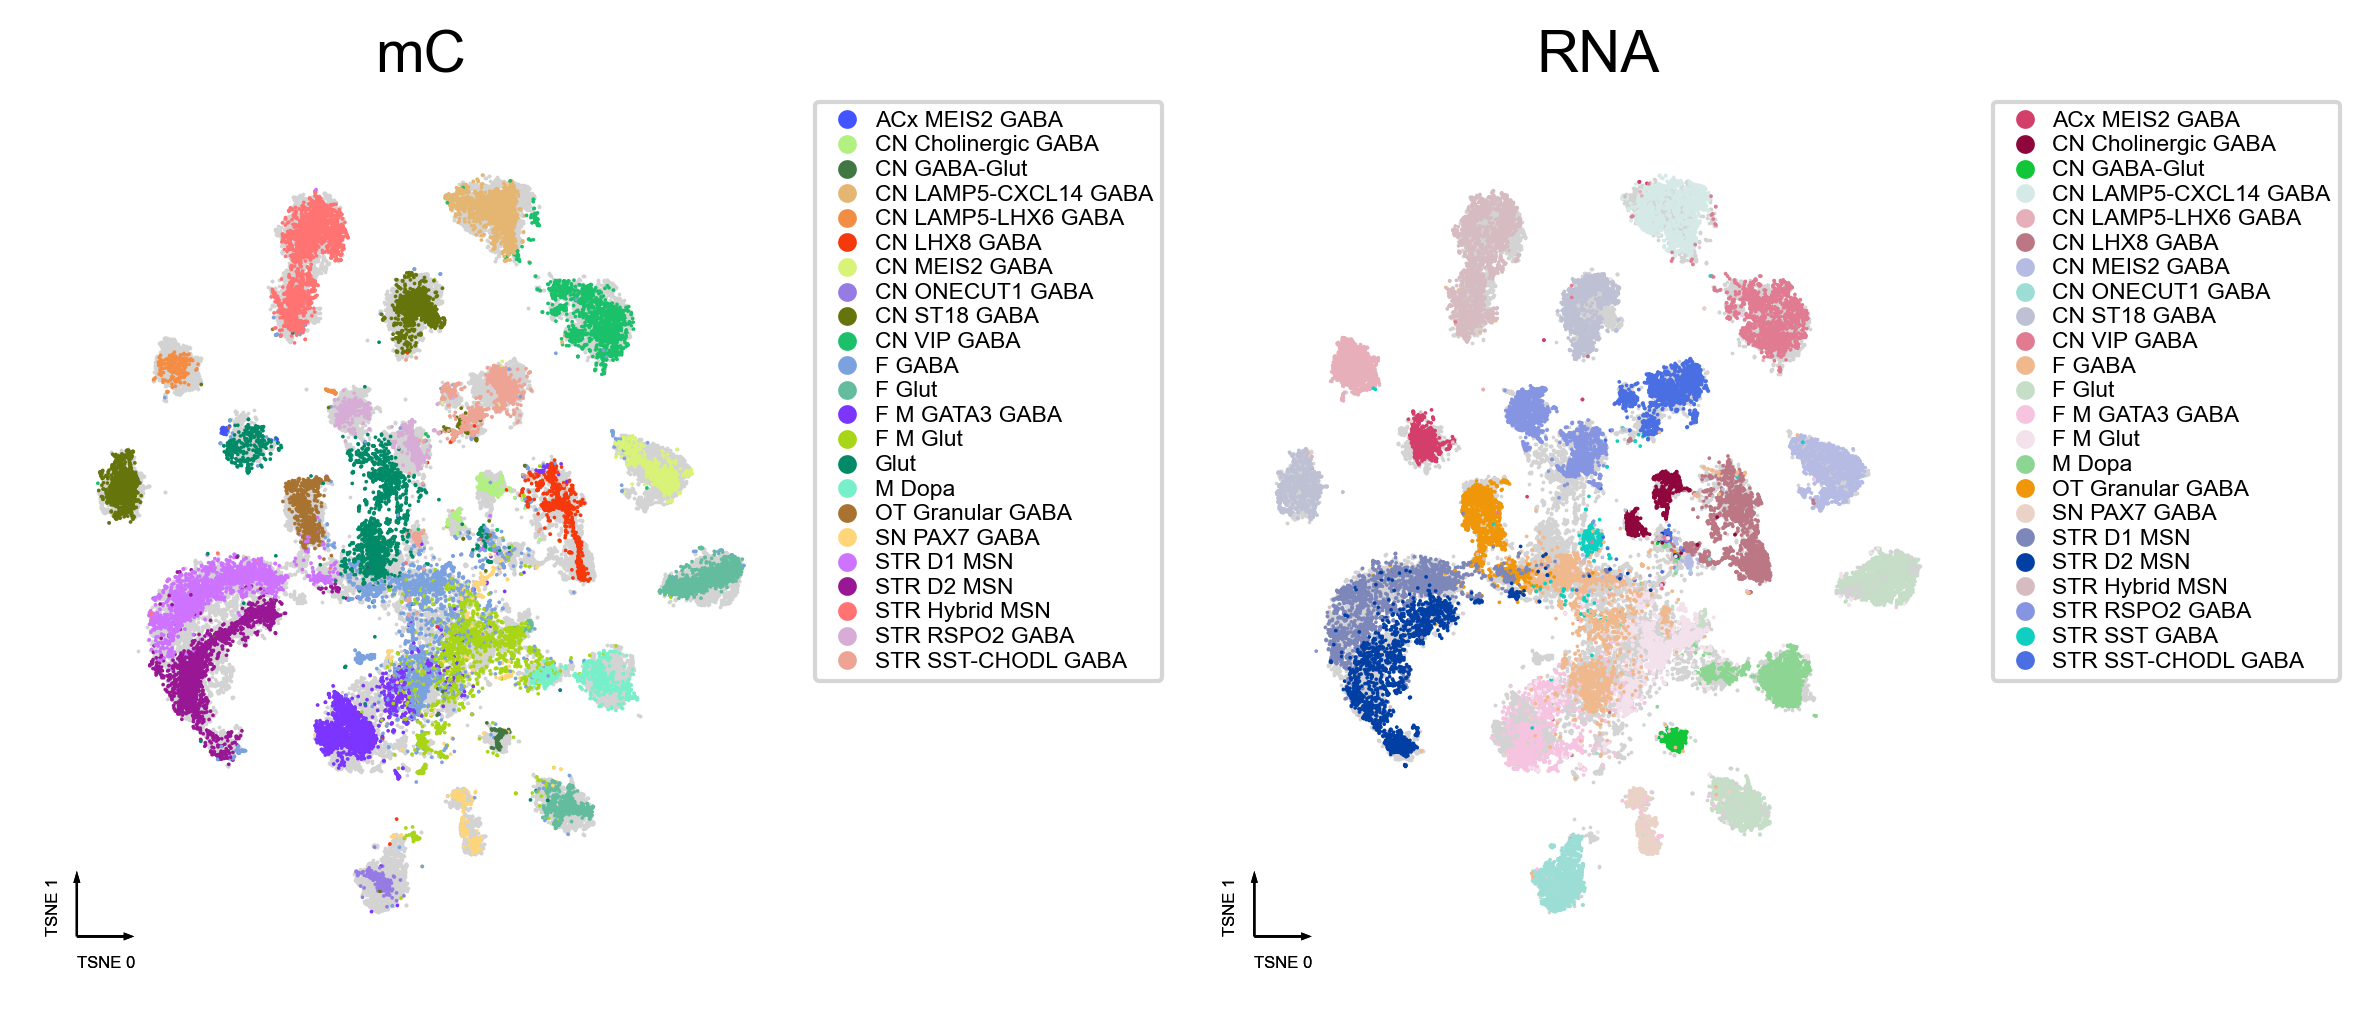

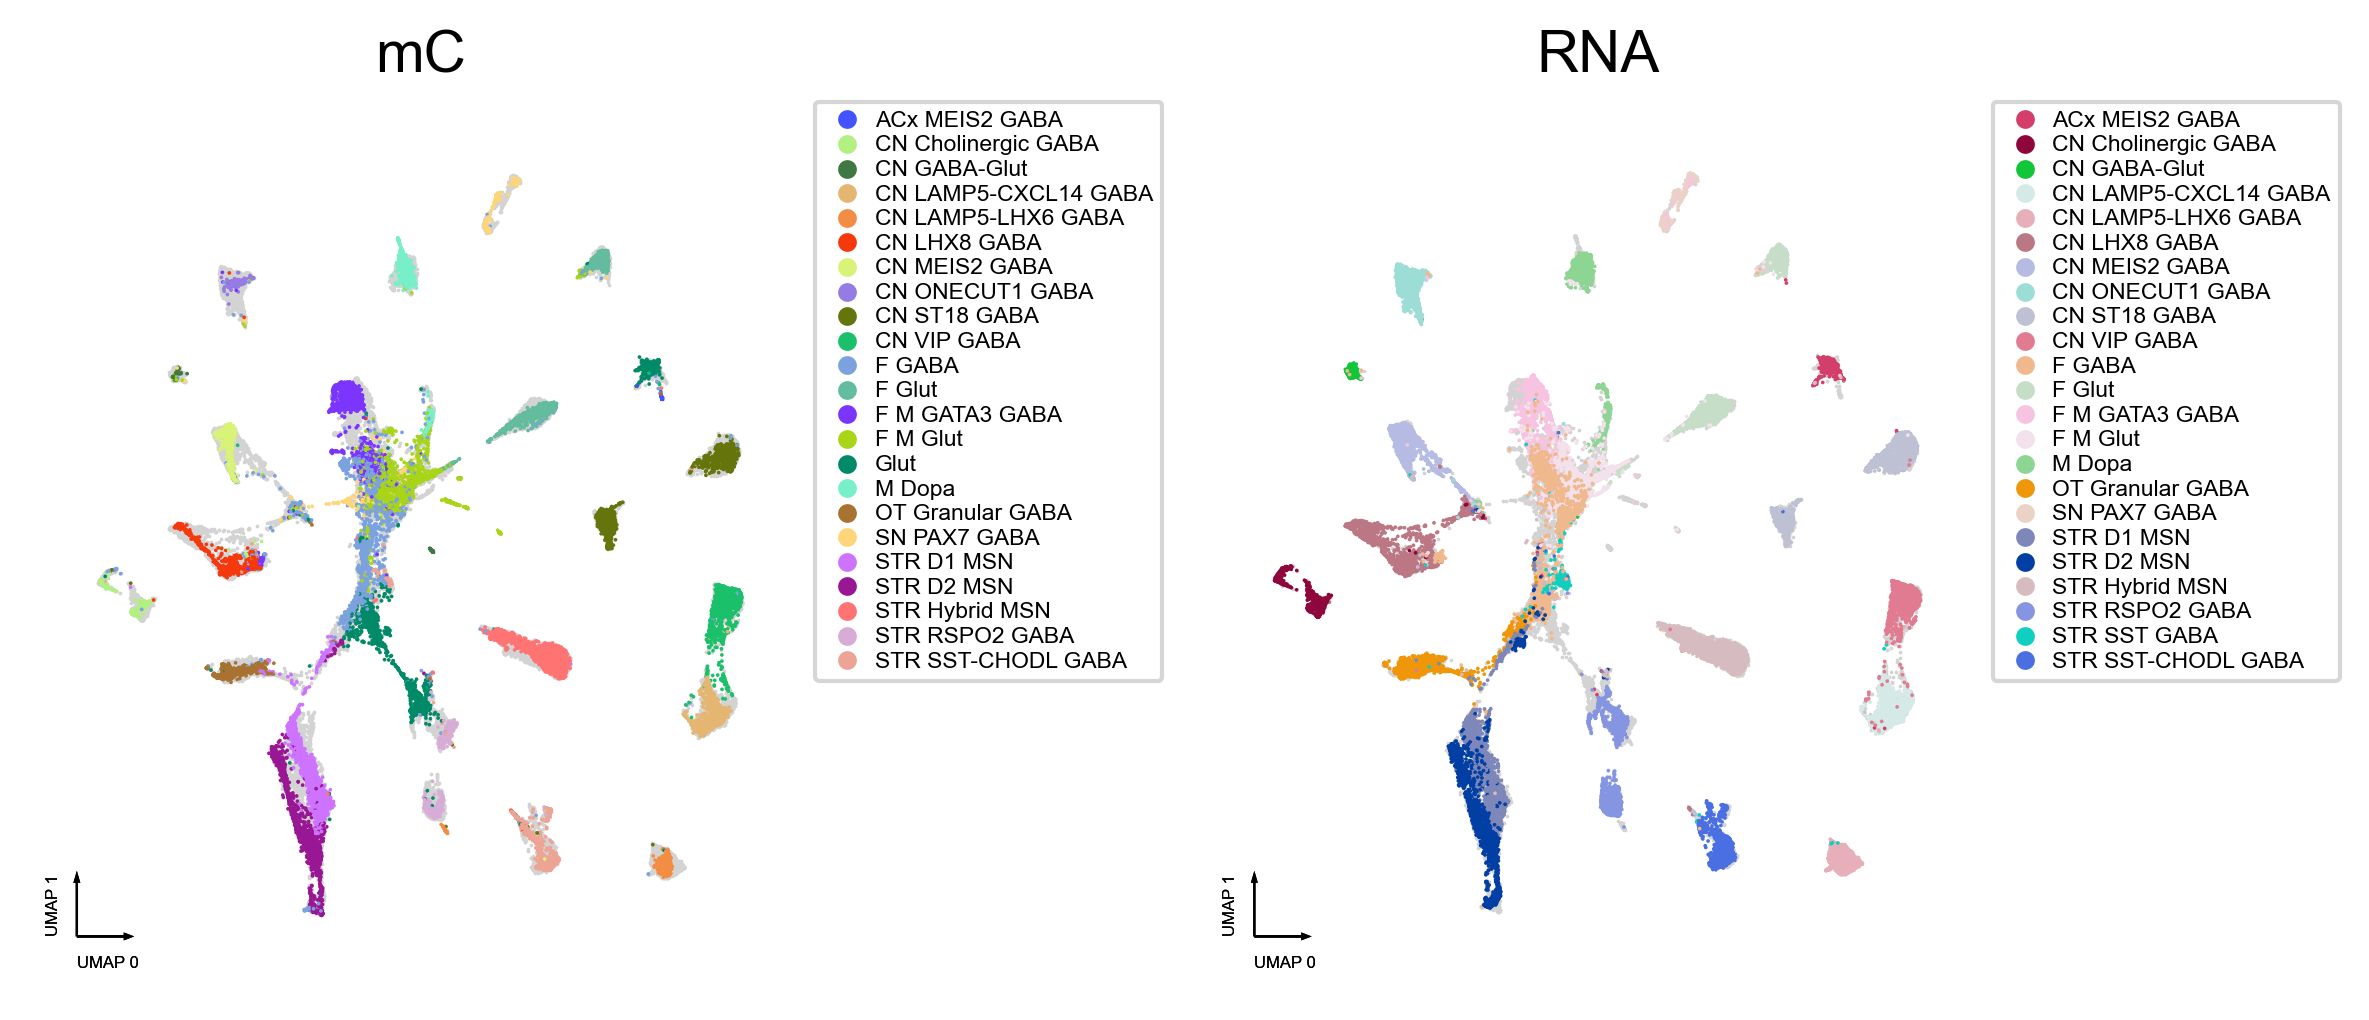

In [108]:
for coord_base in ['tsne', 'umap']:
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8, 3.5),dpi=300,constrained_layout=True)
    for ax,col,modality in zip(axes,hue_cols,modalities):
        adata=adata_dict[modality]
        colors={cluster:color for cluster,color in zip(adata.obs[col].cat.categories.tolist(),adata.uns[f'{col}_colors'])}
        ncol=2 if len(colors)>40 else 1
        categorical_scatter(data=adata_merge[adata_merge.obs['Modality'] != modality],
                            coord_base=coord_base,
                            max_points=None,hue=None,
                            scatter_kws=dict(color='lightgrey'),ax=ax)
        categorical_scatter(data=adata,
                            ax=ax,coord_base=coord_base,
                            hue=col,
                            palette=colors,
                            max_points=None,
                            # dodge_text=True,dodge_kws={
                            #          "force_points": (15, 1),
                            #           'autoalign':'y'},
                            show_legend=True,
                            legend_kws=dict(
                                ncol=ncol,loc='upper left',bbox_to_anchor=(1,1),
                                borderpad=0.4, # pad between marker (text) and border
                                labelspacing=0.2, #The vertical space between the legend entries, in font-size units
                                handleheight=0.5, #The height of the legend handles, in font-size units.
                                handletextpad=0.2, # The pad between the legend handle (marker) and text, in font-size units.
                                borderaxespad=0.2, # The pad between the Axes and legend border, in font-size units
                                columnspacing=0.2, #The spacing between columns, in font-size units
                                fontsize=5.5,title_fontsize=6
                                )
                           )
        ax.set_title(modality,fontsize=14)
    plt.subplots_adjust(hspace=0,wspace=0,left=0,right=0)
    fig.tight_layout()
    fig.savefig(f"figures/seurat.integrated.{coord_base}_with_legend.pdf",dpi=300,bbox_inches='tight') #
    plt.show()

In [ ]:
for coord_base in ['tsne', 'umap']:
    #fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12, 4),dpi=300,constrained_layout=True)
    col="leiden"
    fig, ax = plt.subplots(figsize=(5,4), dpi=300)
    colors={cluster:color for cluster,color in zip(adata_merge.obs[col].cat.categories.tolist(),adata_merge.uns[f'{col}_colors'])}
    categorical_scatter(data=adata_merge,
                        ax=ax,coord_base=coord_base,
                        hue=col,text_anno=adata.obs[col].cat.codes.map(str),#text_anno=col,
                        palette=colors,
                        max_points=None,
                        text_kws=dict(color='white',fontweight="bold",fontsize=4,
                                     bbox=dict(facecolor=colors,boxstyle='circle', #ellipse, round
                                               edgecolor='white',fill=True,linewidth=0.5,alpha=0.75)),
                        luminance=0.48,
                        # dodge_text=True,dodge_kws={
                        #          "force_points": (15, 1),
                        #           'autoalign':'y'},
                        show_legend=True,#legend_kws=dict(ncol=1)
                       )
    ax.set_title(col,fontsize=14)
    fig.tight_layout()
    fig.savefig(f"figures/seurat.integrated.leiden.{coord_base}.pdf",dpi=300,bbox_inches='tight') #
    plt.show()

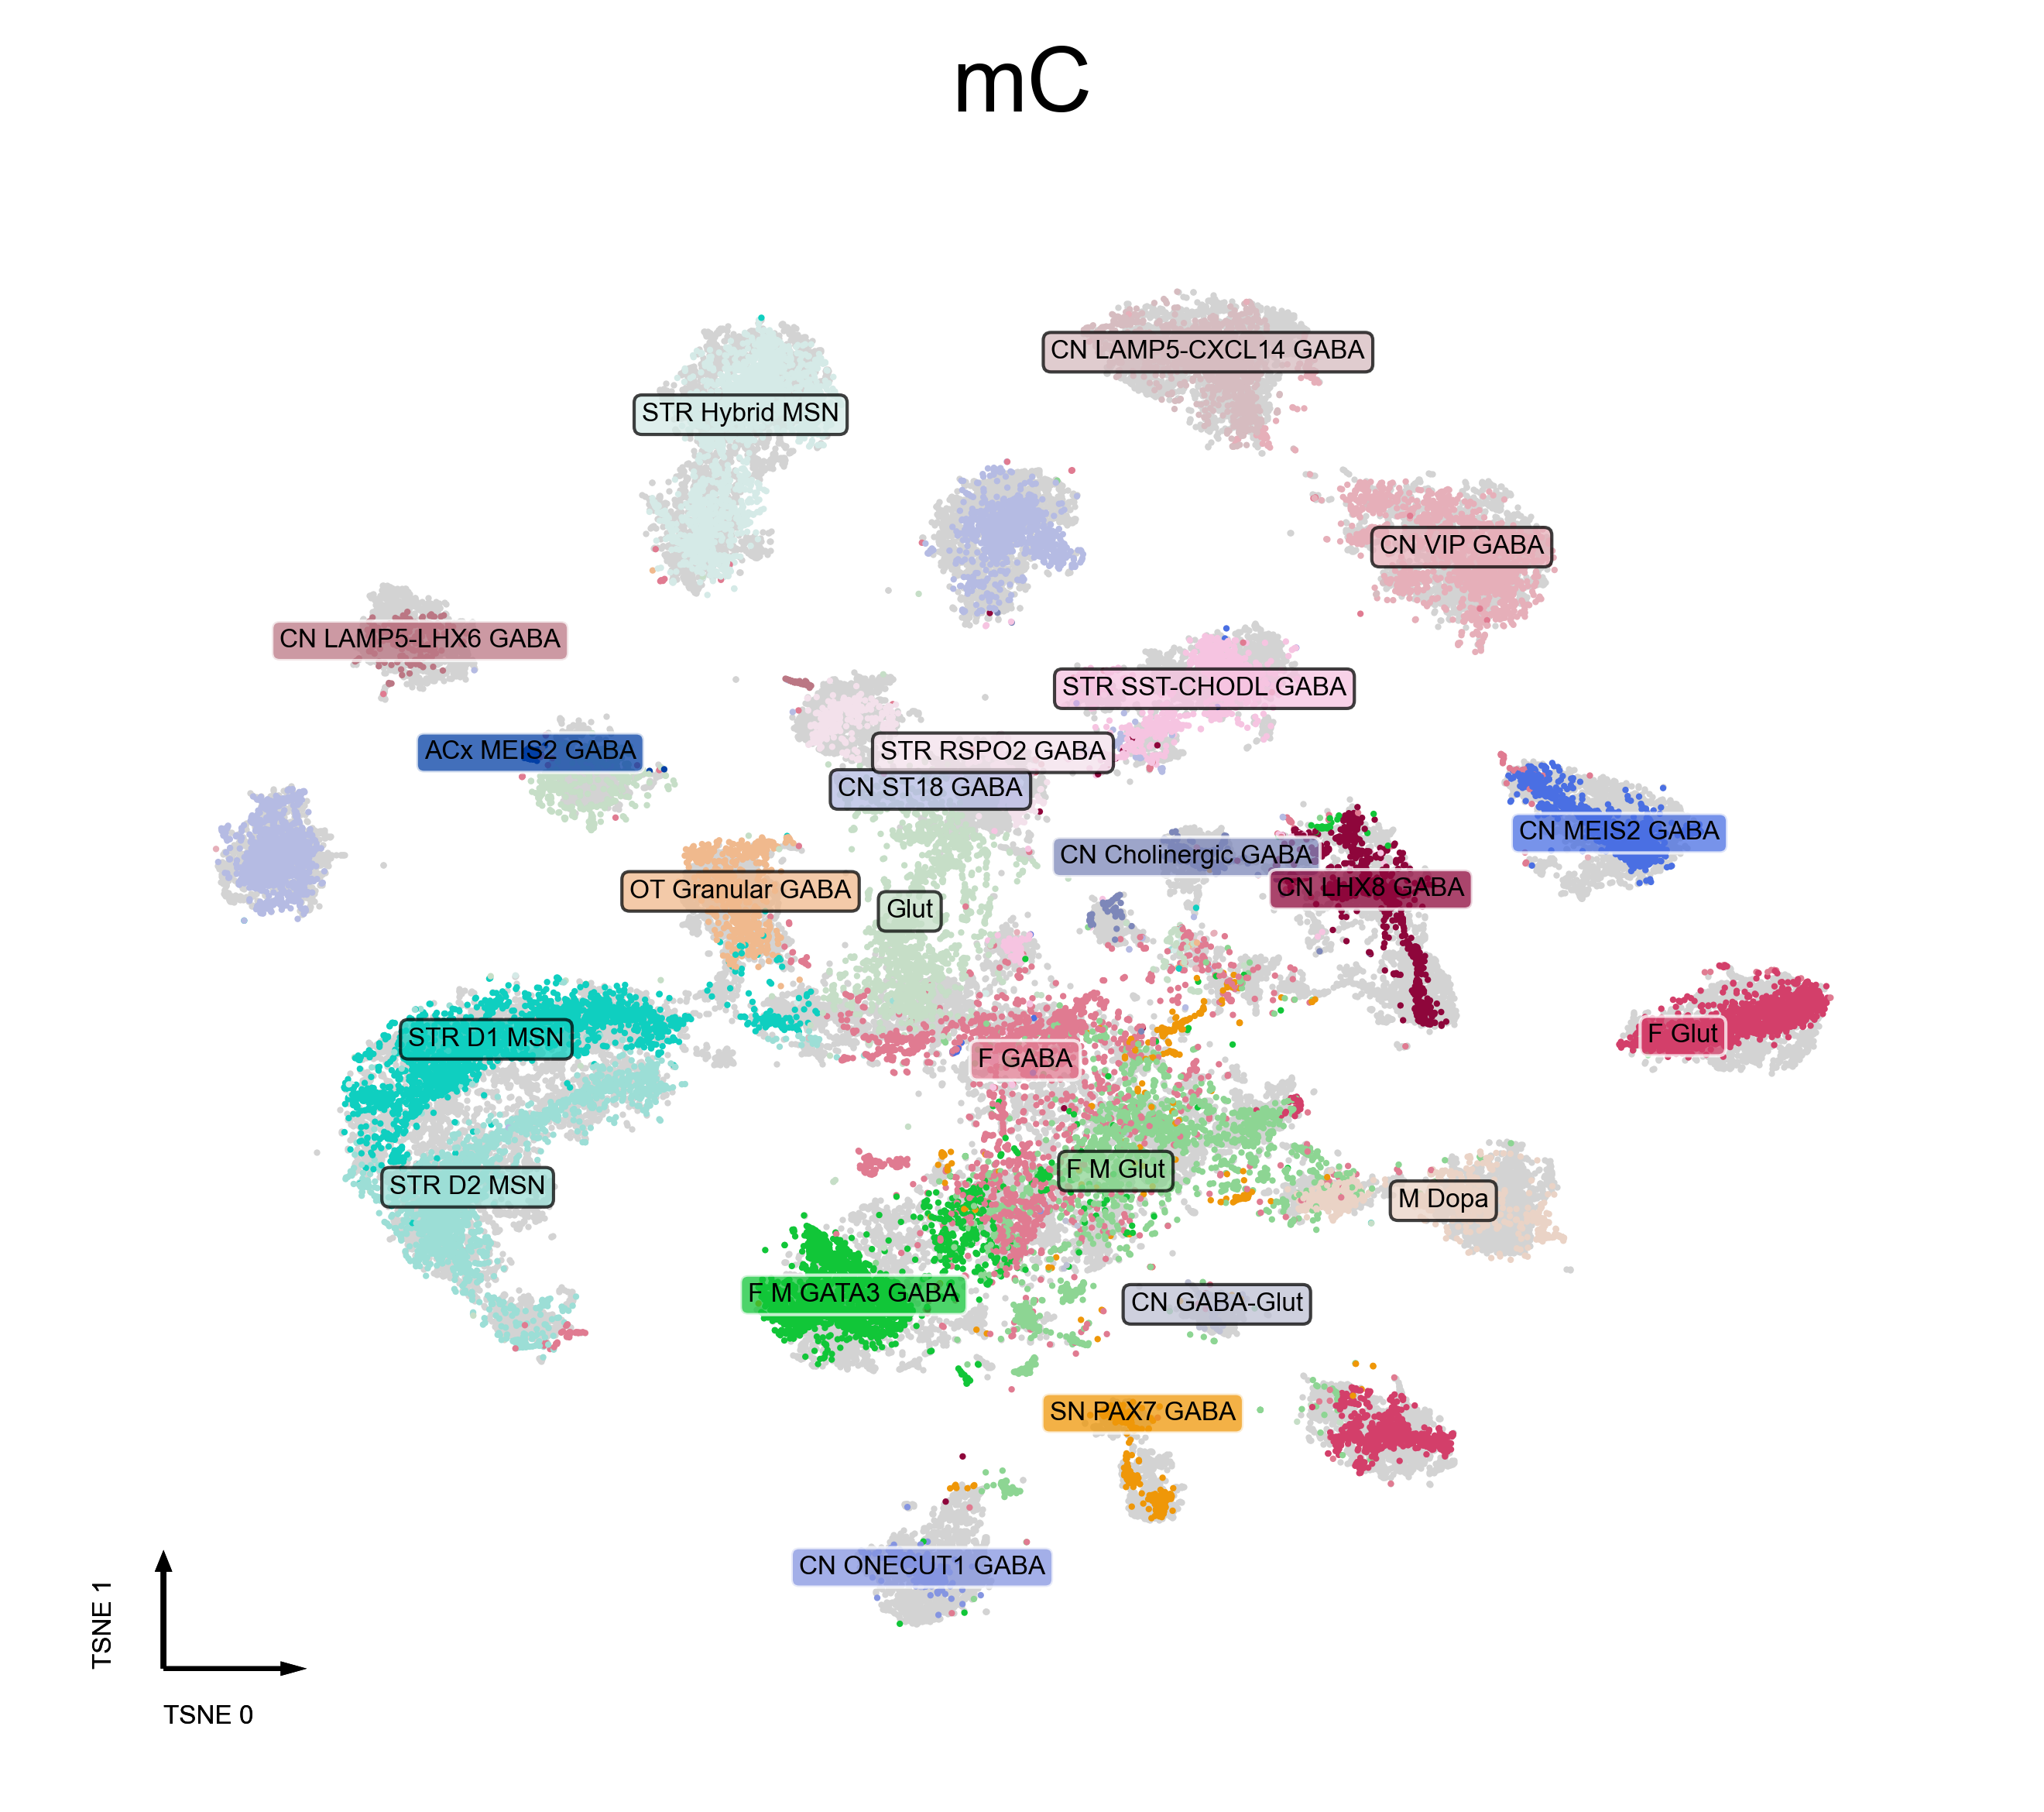

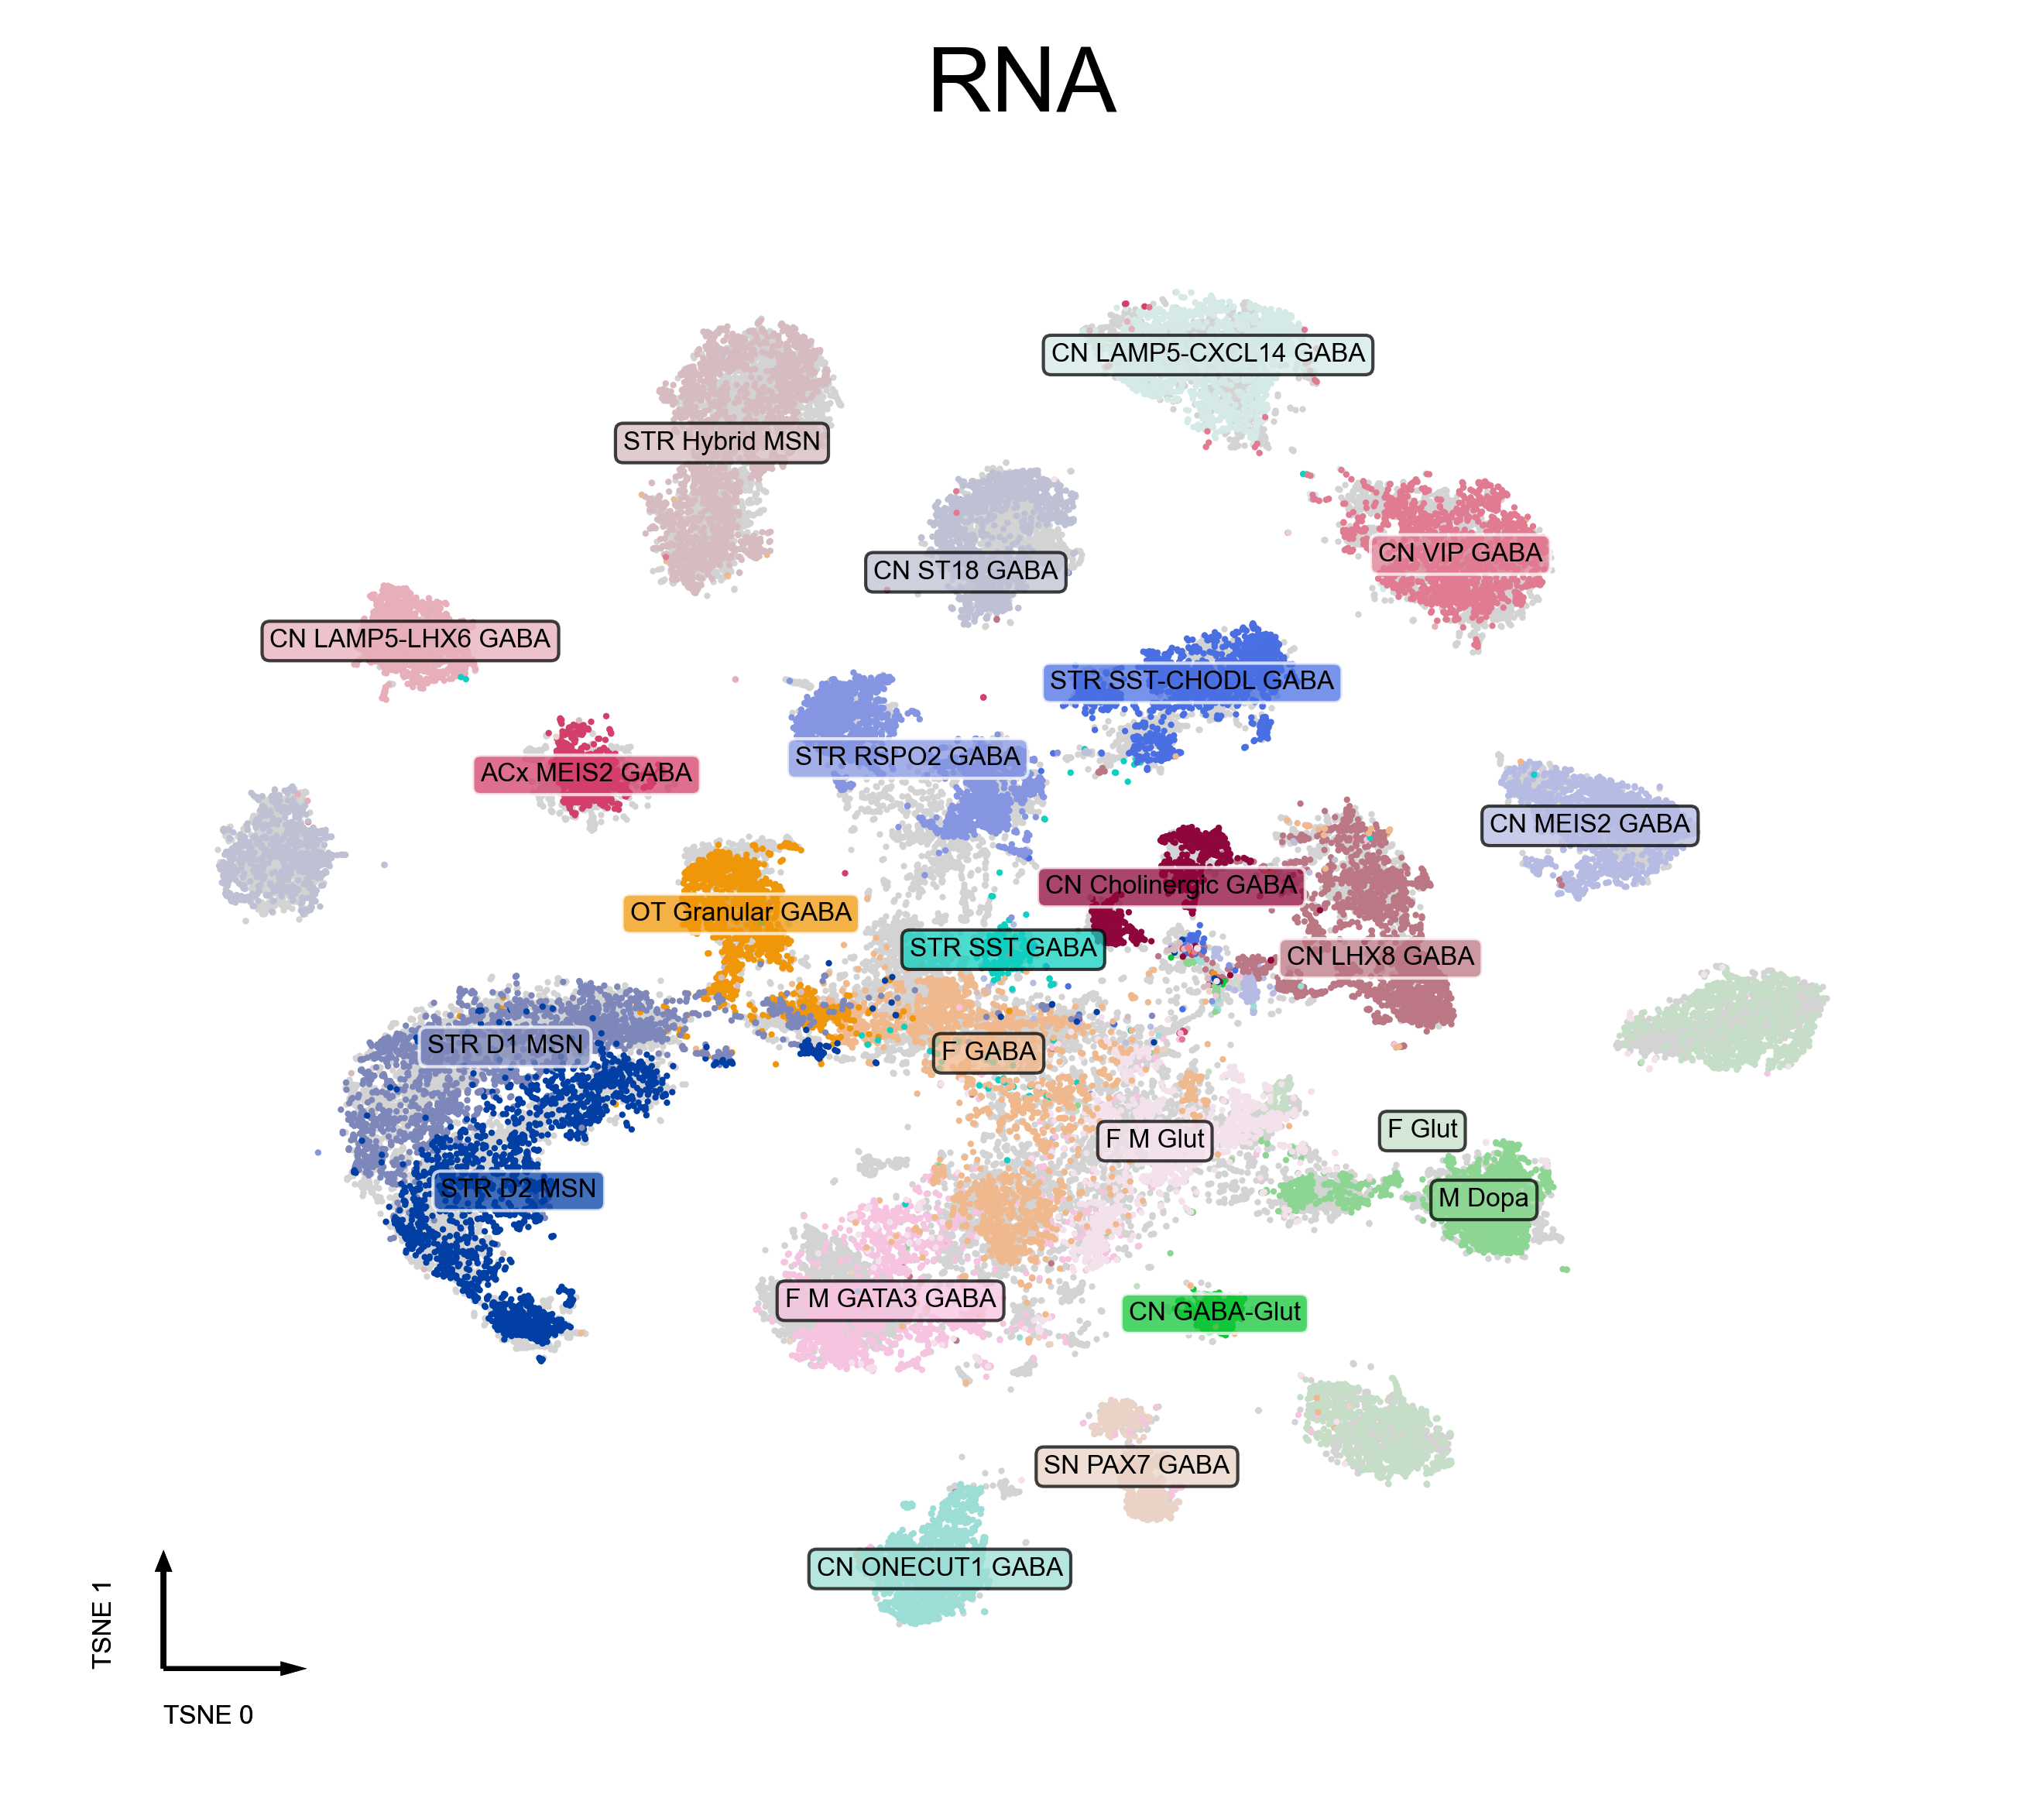

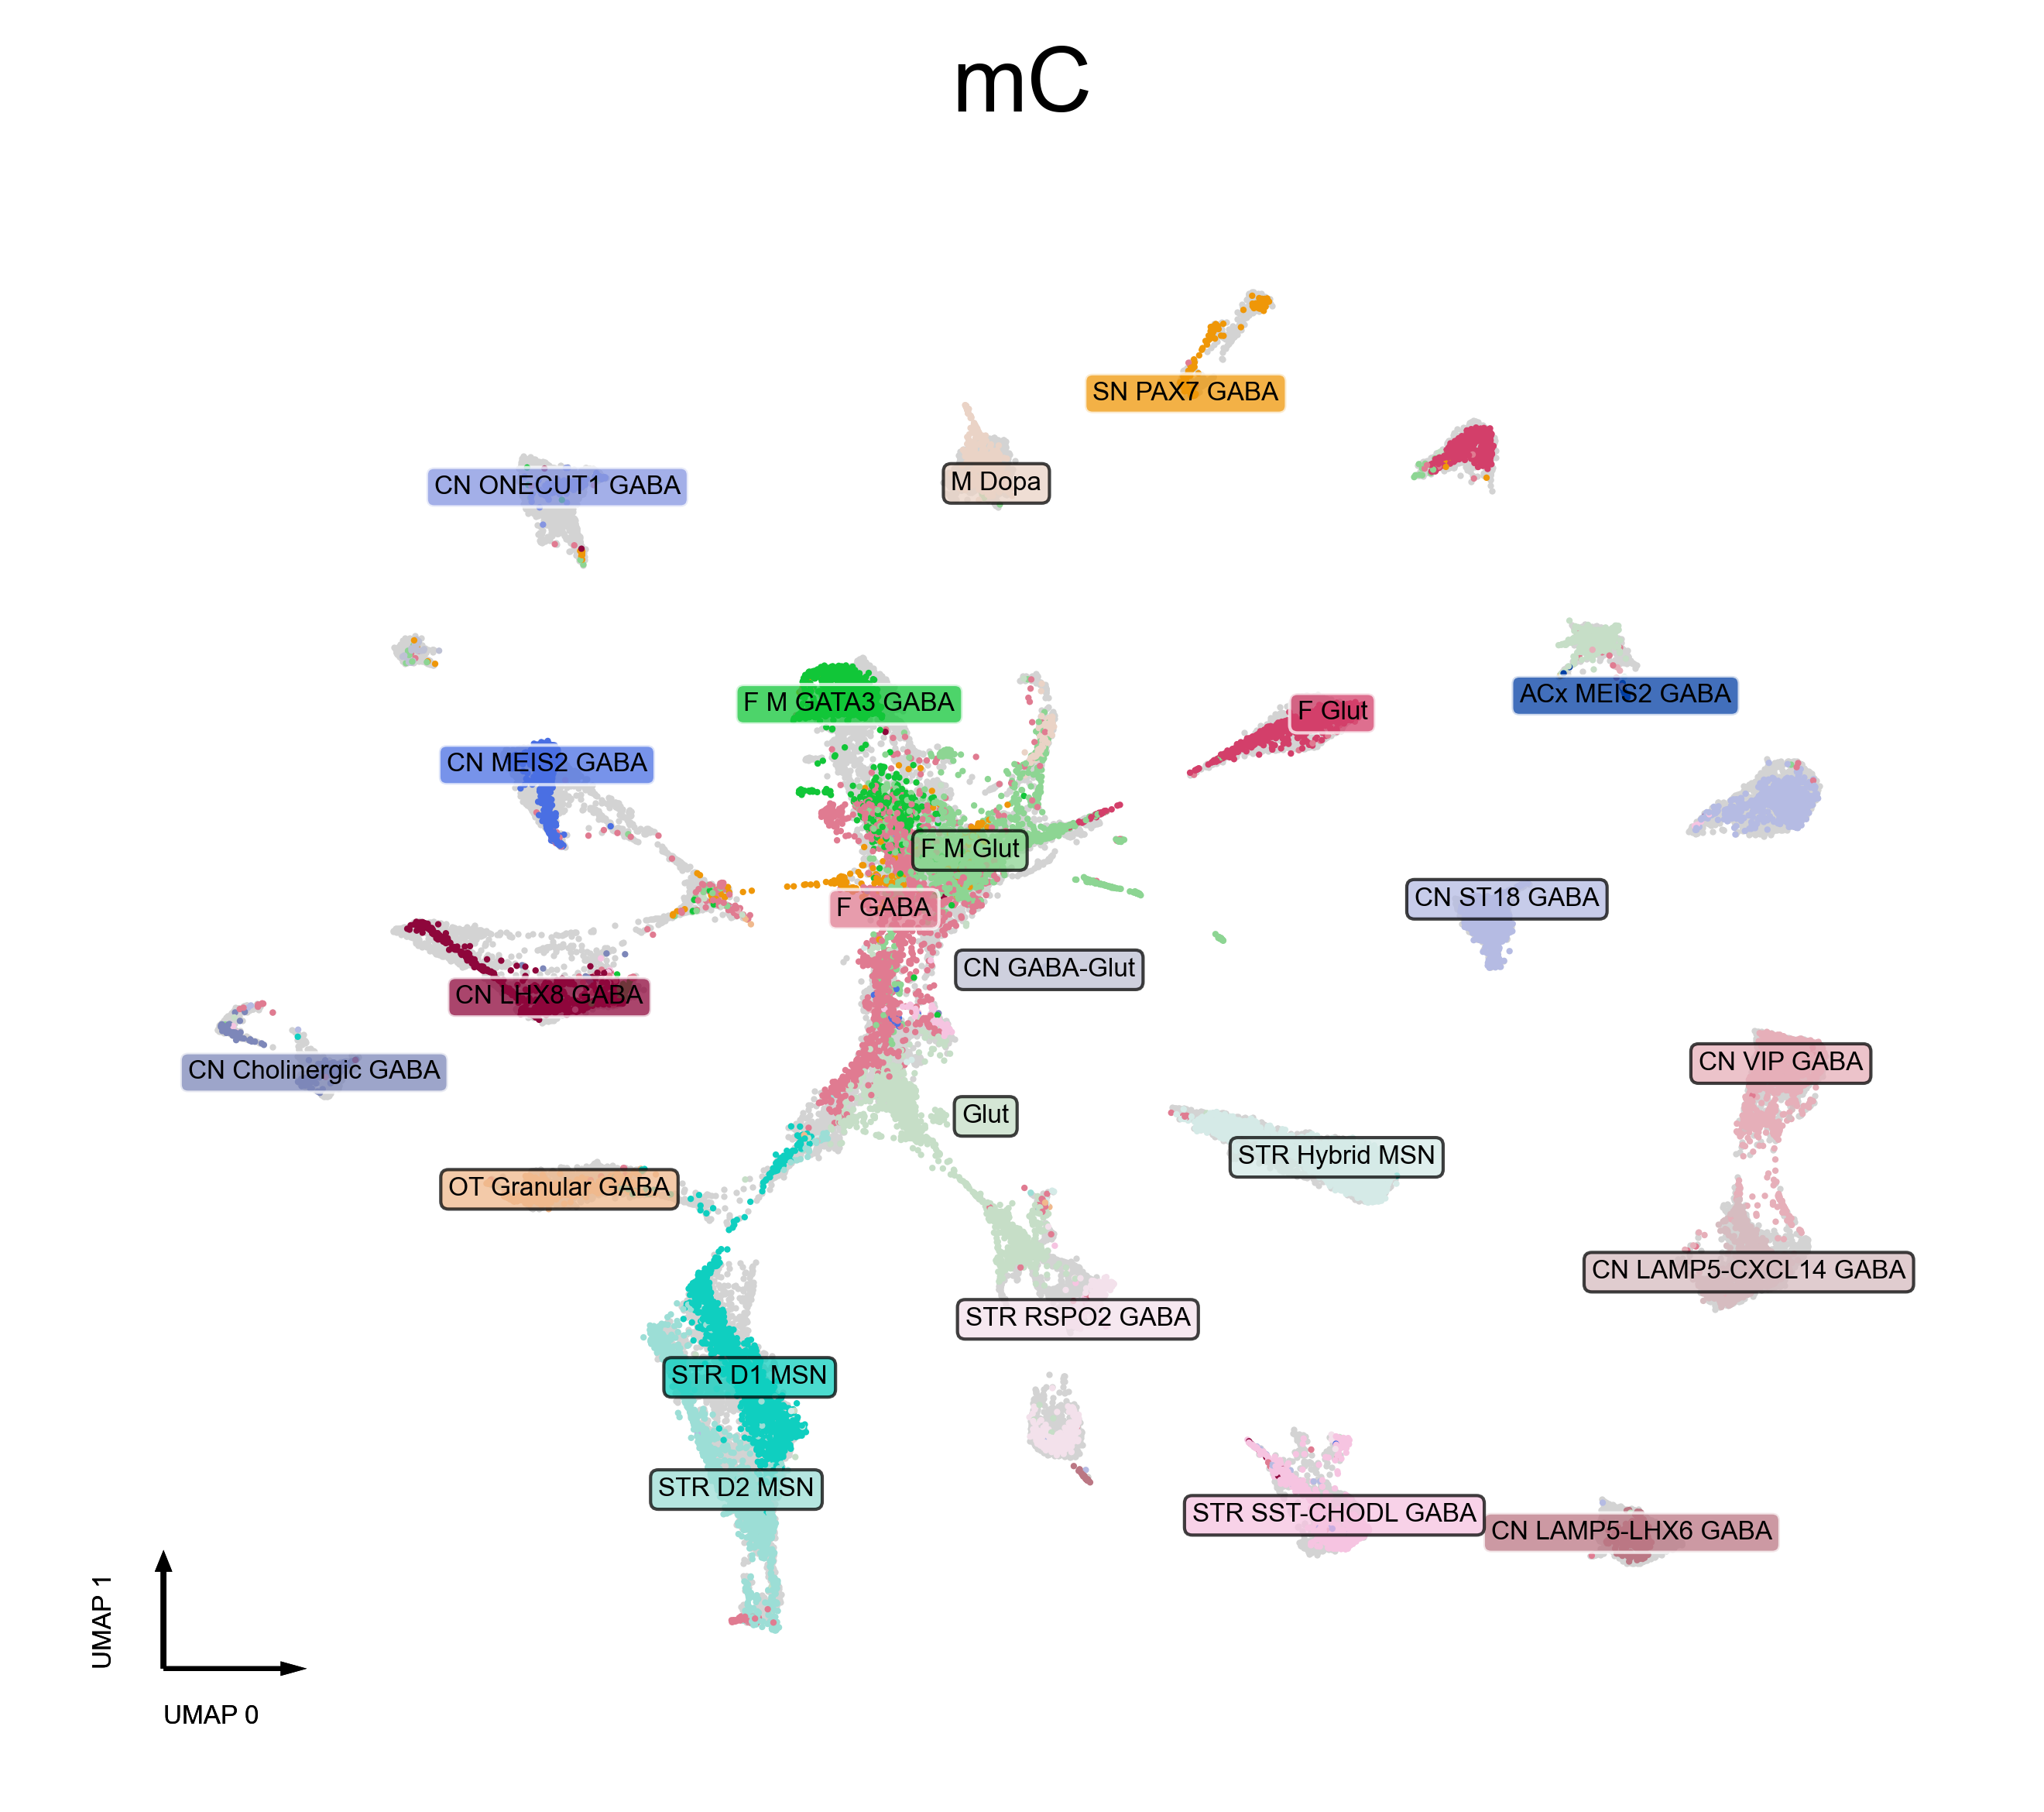

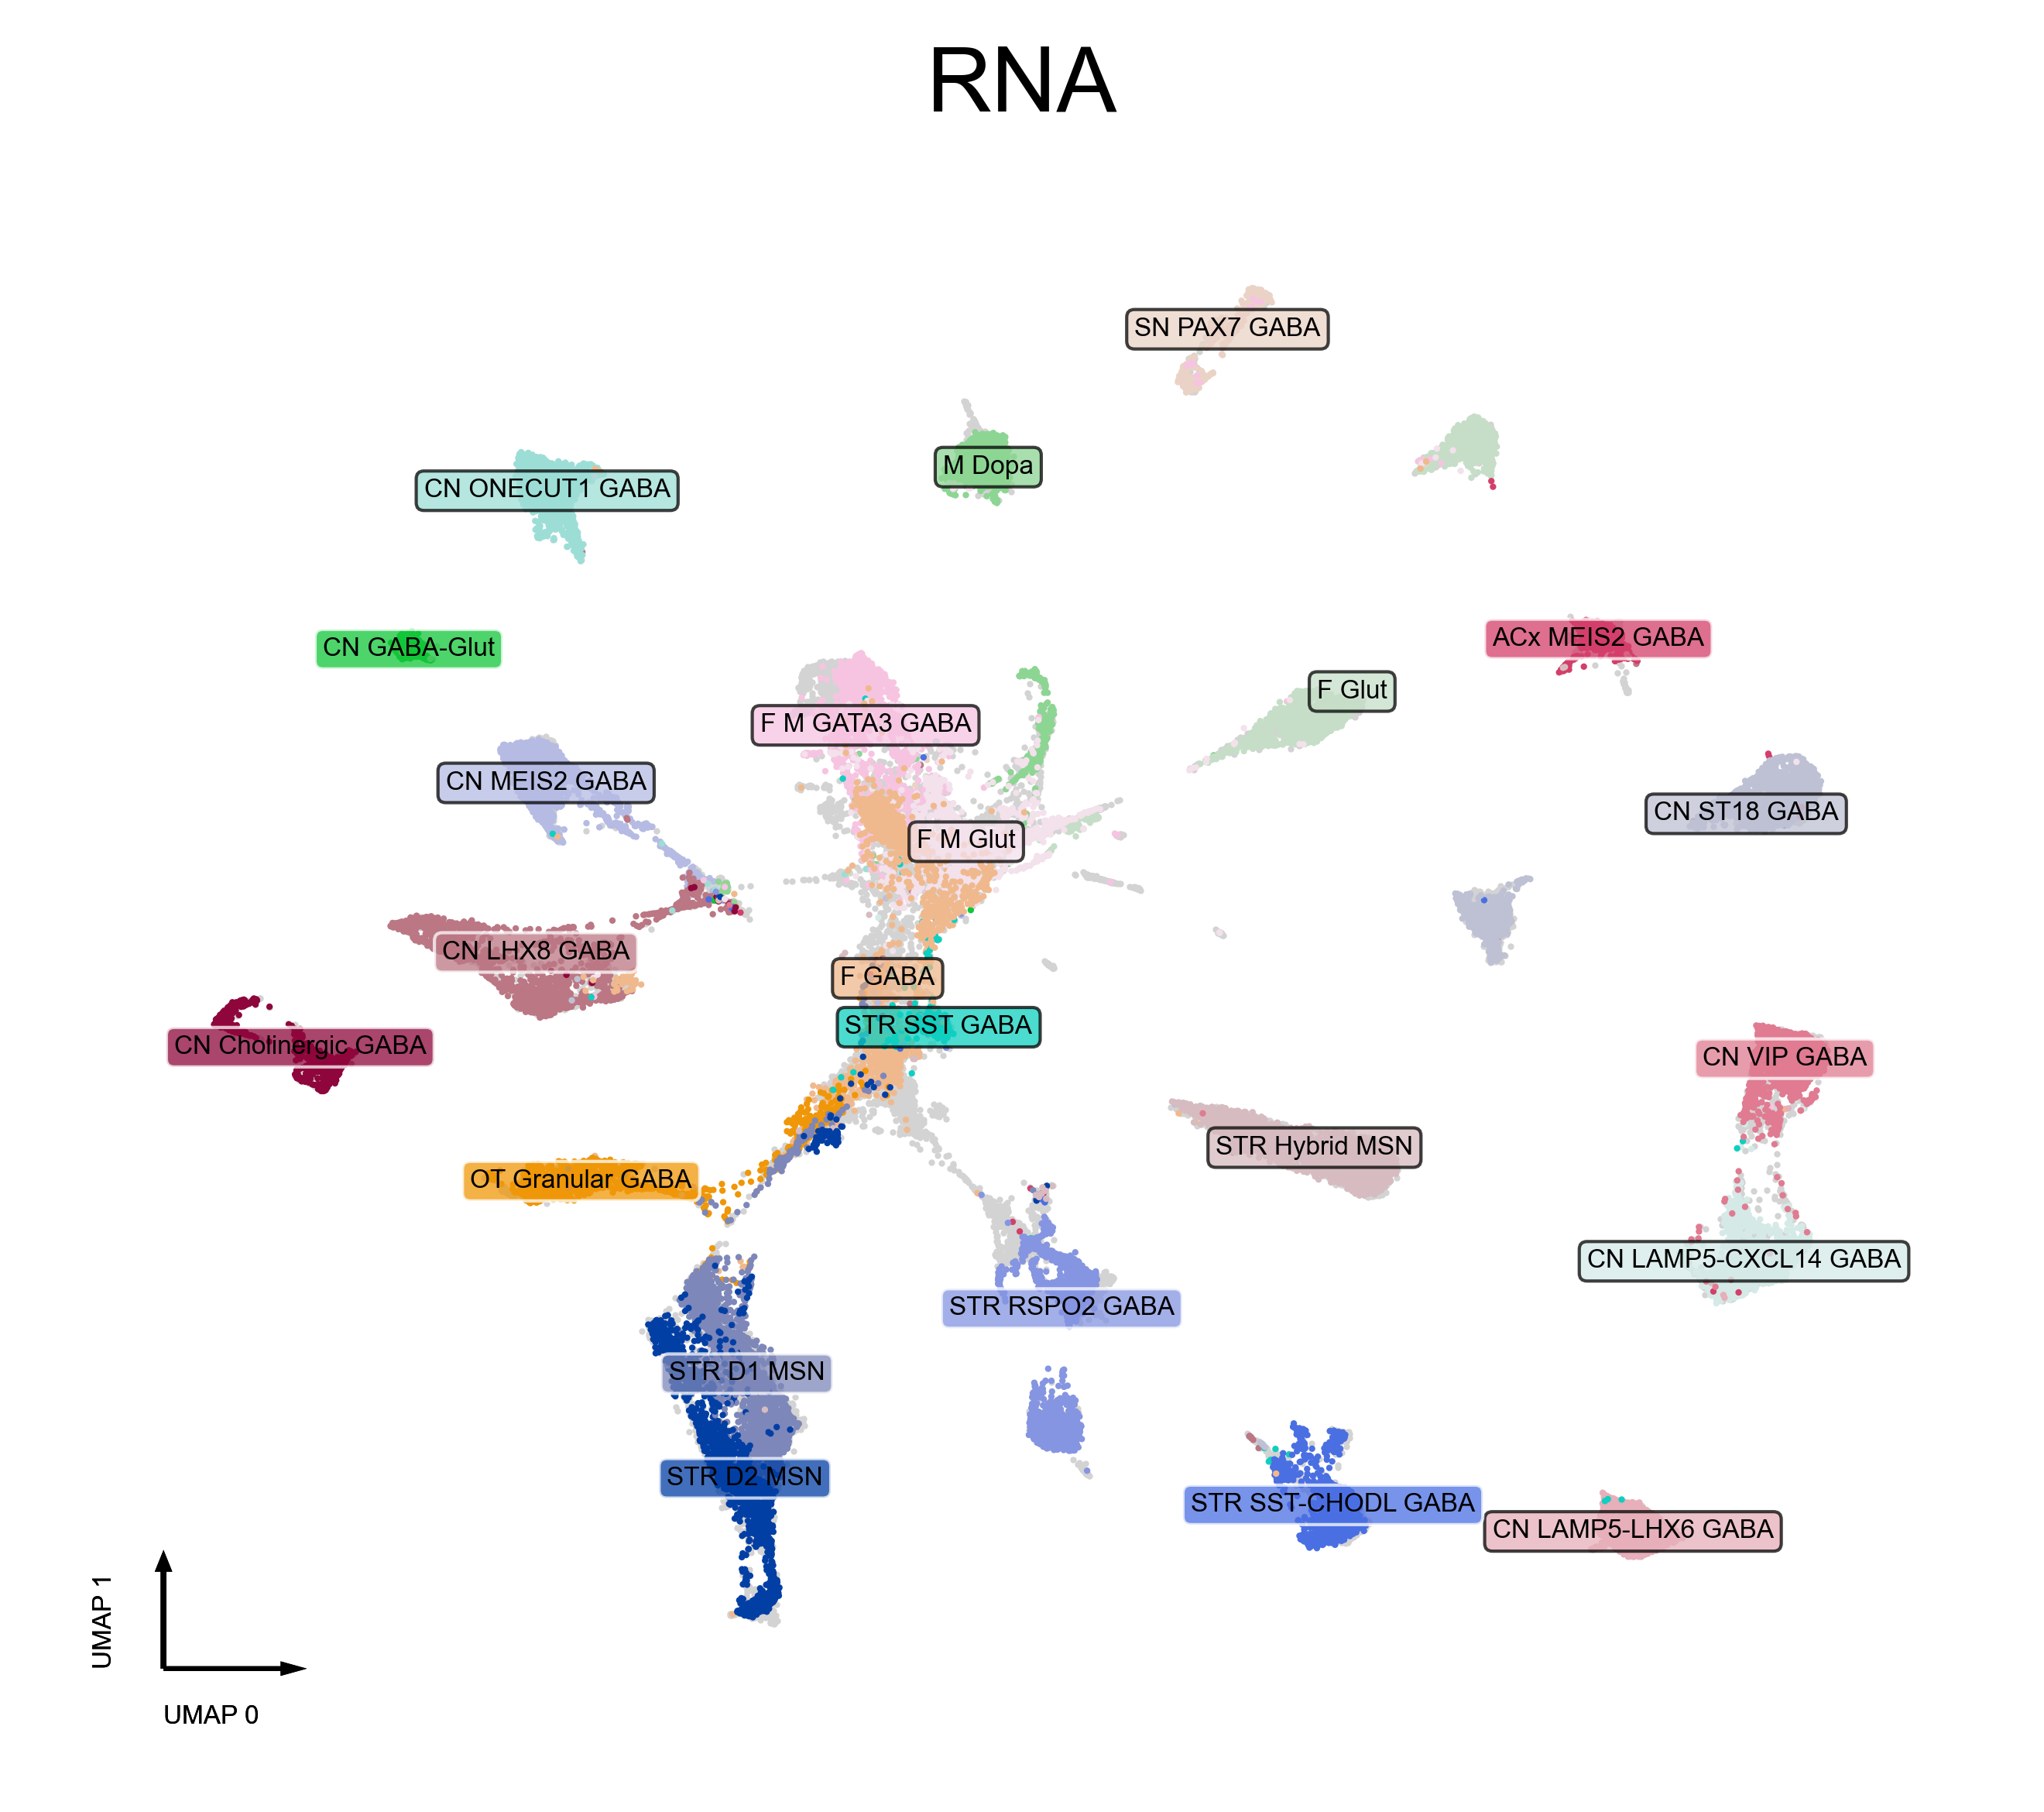

In [62]:
for coord_base in ['tsne', 'umap']:
    #fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12, 4),dpi=300,constrained_layout=True)
    for col,modality in zip(hue_cols,modalities):
        fig, ax = plt.subplots(figsize=(4.5, 4), dpi=300)
        adata=adata_dict[modality]
        colors={cluster:color for cluster,color in zip(adata.obs[col].cat.categories.tolist(),adata.uns[f'{col}_colors'])}
        ncol=2 if len(colors)>20 else 1
        categorical_scatter(data=adata_merge[adata_merge.obs['Modality'] != modality],
                            coord_base=coord_base,
                            max_points=None,hue=None,
                            scatter_kws=dict(color='lightgrey'),ax=ax)
        categorical_scatter(data=adata,
                            ax=ax,coord_base=coord_base,
                            hue=col,text_anno=col,
                            palette=colors,
                            max_points=None,
                            text_kws=dict(color='black',fontweight="bold",fontsize=4,#fontstretch='ultra-condensed',
                                     bbox=dict(facecolor=colors,boxstyle='round', #ellipse, round
                                               edgecolor='white',fill=True,linewidth=0.5,alpha=0.75)),
                            luminance=0.48,
                            # dodge_text=True,dodge_kws={
                            #          "force_points": (15, 1),
                            #           'autoalign':'y'},
                            show_legend=False,legend_kws=dict(ncol=ncol,fontsize=5.5))
        ax.set_title(modality,fontsize=14)
        fig.tight_layout()
        fig.savefig(f"figures/seurat.integrated.{modality}.{coord_base}_without_legend.pdf",dpi=300,bbox_inches='tight') #
        plt.show()

In [111]:
adata_merge.obs.Modality.value_counts()

Modality
RNA    34555
mC     27294
Name: count, dtype: int64

In [ ]:
coord_base='umap'
col='FOSL2'
for modality in zip(hue_cols,modalities):
    fig, ax = plt.subplots(figsize=(4.5, 4), dpi=300)
    adata=adata_dict[modality]
    colors={cluster:color for cluster,color in zip(adata.obs[col].cat.categories.tolist(),adata.uns[f'{col}_colors'])}
    ncol=2 if len(colors)>20 else 1
    categorical_scatter(data=adata_merge[adata_merge.obs['Modality'] != modality],
                        coord_base=coord_base,
                        max_points=None,hue=None,
                        scatter_kws=dict(color='lightgrey'),ax=ax)
    categorical_scatter(data=adata,
                        ax=ax,coord_base=coord_base,
                        hue=col,text_anno=col,
                        palette=colors,
                        max_points=None,
                        text_kws=dict(color='black',fontweight="bold",fontsize=4,#fontstretch='ultra-condensed',
                                 bbox=dict(facecolor=colors,boxstyle='round', #ellipse, round
                                           edgecolor='white',fill=True,linewidth=0.5,alpha=0.75)),
                        luminance=0.48,
                        # dodge_text=True,dodge_kws={
                        #          "force_points": (15, 1),
                        #           'autoalign':'y'},
                        show_legend=False,legend_kws=dict(ncol=ncol,fontsize=5.5))
    ax.set_title(modality,fontsize=14)
    fig.tight_layout()
    fig.savefig(f"figures/seurat.integrated.{modality}.{coord_base}_FOSL2.pdf",dpi=300,bbox_inches='tight') #
    plt.show()

In [ ]:
for coord_base in ['tsne', 'umap']:
    #fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12, 4),dpi=300,constrained_layout=True)
    for col,modality in zip(hue_cols,modalities):
        fig, ax = plt.subplots(figsize=(5,4), dpi=300)
        adata=adata_dict[modality]
        ct2code=adata.obs.assign(code=adata.obs[col].cat.codes).loc[:,[col,'code']].drop_duplicates().set_index(col).code.to_dict()
        id_colors={str(ct2code[cluster]):color for cluster,color in zip(adata.obs[col].cat.categories.tolist(),adata.uns[f'{col}_colors'])}
        colors={f"{ct2code[cluster]}: {cluster}":color for cluster,color in zip(adata.obs[col].cat.categories.tolist(),adata.uns[f'{col}_colors'])}
        ncol=2 if len(colors)>40 else 1
        adata.obs[f'code_{col}']=adata.obs[col].apply(lambda x:f"{ct2code[x]}: {x}")
        categorical_scatter(data=adata_merge[adata_merge.obs['Modality'] != modality],
                            coord_base=coord_base,
                            max_points=None,hue=None,
                            scatter_kws=dict(color='lightgrey'),ax=ax)
        categorical_scatter(data=adata,
                            ax=ax,coord_base=coord_base,
                            hue=f'code_{col}',text_anno=adata.obs[col].cat.codes.map(str),#text_anno=col,
                            palette=colors,
                            max_points=None,#text_anno_palette=id_colors,
                            #text_anno=mc_data.obs[mc_col].replace(mask_dict_mc),
                            text_kws=dict(color='white',fontweight="bold",fontsize=4,
                                     bbox=dict(facecolor=id_colors,boxstyle='round', #ellipse, round,circle
                                               edgecolor='white',fill=True,linewidth=0.5,alpha=0.75)),
                            luminance=0.48,
                            # dodge_text=True,dodge_kws={
                            #          "force_points": (15, 1),
                            #           'autoalign':'y'},
                            show_legend=True,
                            legend_kws=dict(
                                ncol=ncol,loc='upper left',bbox_to_anchor=(1,1),
                                borderpad=0.4, # pad between marker (text) and border
                                labelspacing=0.2, #The vertical space between the legend entries, in font-size units
                                handleheight=0.5, #The height of the legend handles, in font-size units.
                                handletextpad=0.2, # The pad between the legend handle (marker) and text, in font-size units.
                                borderaxespad=0.2, # The pad between the Axes and legend border, in font-size units
                                columnspacing=0.2, #The spacing between columns, in font-size units
                                fontsize=5.5,title_fontsize=6
                                )
                           )
        ax.set_title(modality,fontsize=14)
        fig.tight_layout()
        fig.savefig(f"figures/seurat.integrated.{modality}.{coord_base}_with_code.pdf",dpi=300,bbox_inches='tight') #
        plt.show()

In [64]:
# coord_base='umap'
# adata=adata_dict['mC']
# col='L2'
# fig, ax = plt.subplots(figsize=(5,4), dpi=300)
# colors={cluster:color for cluster,color in zip(adata.obs[col].cat.categories.tolist(),adata.uns[f'{col}_colors'])}
# ncol=2 if len(colors)>20 else 1
# categorical_scatter(data=adata_merge[adata_merge.obs['Modality'] != modality],
#                     coord_base=coord_base,
#                     max_points=None,hue=None,
#                     scatter_kws=dict(color='lightgrey'),ax=ax)
# colors1={'c5':'blue','c2':'red'}
# use_cells=adata.obs.loc[adata.obs['L2'].isin(list(colors1.keys()))].index.tolist()
# categorical_scatter(data=adata[use_cells,:],
#                     ax=ax,coord_base=coord_base,
#                     hue=col,text_anno=col,
#                     palette=colors1,sizes=10,
#                     max_points=None,
#                     text_kws=dict(color='black',fontweight="bold",fontsize=4,#fontstretch='ultra-condensed',
#                              bbox=dict(facecolor=colors1,boxstyle='round', #ellipse, round
#                                        edgecolor='white',fill=True,linewidth=0.5,alpha=0.75)),
#                     luminance=0.48,
#                     # dodge_text=True,dodge_kws={
#                     #          "force_points": (15, 1),
#                     #           'autoalign':'y'},
#                     show_legend=False,legend_kws=dict(ncol=ncol))
# ax.set_title(modality,fontsize=10)
# fig.tight_layout()
# fig.savefig(f"figures/seurat.integrated.{modality}.{coord_base}.pdf",dpi=300,bbox_inches='tight') #
# plt.show()

## Confusion Matrix

In [ ]:
use_adata=adata_merge[adata_merge.obs['Modality'] == 'mC'].to_memory()
if rna_cell_type==mc_cell_type:
    new_rna_cell_type=f'RNA.{rna_cell_type}'
    # use_adata.obs.rename(columns={rna_cell_type:new_rna_cell_type},inplace=True)
    rna_cell_type=new_rna_cell_type
key=rna_cell_type
df=use_adata.obs.loc[:,[mc_cell_type,f'infer_{key}',f'infer_{key}_prob']]
df=df.loc[df[f'infer_{key}_prob']>=0.5]
D=df[f'infer_{key}'].to_dict()
use_adata.obs[key]=use_adata.obs_names.map(D)
use_obs=df.index.tolist()
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.tsne(use_adata[use_obs,:], color=[f'infer_{key}',f'infer_{key}_prob'],
               wspace=0.8)
    sc.pl.umap(use_adata[use_obs,:], color=[f'infer_{key}',f'infer_{key}_prob'],
               wspace=0.8)

In [ ]:
df=use_adata.obs.loc[:,[mc_cell_type,f'infer_{key}']].value_counts().reset_index()
D=df.groupby(mc_cell_type)['count'].sum()
df['N']=df[mc_cell_type].map(D).astype(int)
df['fraction']=df['count'] / df.N
data=df.pivot(index=mc_cell_type,columns=f'infer_{key}',values='fraction')
data

In [ ]:
df_rows=data.index.to_series().to_frame()
cols=data.columns.tolist()
max_idx=np.argmax(data.fillna(0).values,axis=1)
df_rows['GROUP']=[cols[i] for i in max_idx]
use_rows=[]
for col in data.columns.tolist():
    df1=df_rows.loc[df_rows.GROUP==col]
    if df1.shape[0]==0:
        continue
    use_rows.extend(df1[mc_cell_type].unique().tolist())
df_rows=df_rows.loc[use_rows]
ct2code=use_adata.obs.assign(code=use_adata.obs[mc_cell_type].cat.codes).loc[:,[mc_cell_type,'code']].drop_duplicates().set_index(mc_cell_type).code.to_dict()
df_rows['Label']=df_rows[mc_cell_type].apply(lambda x:f"{ct2code[x]}: {x}")
df_rows

Starting..
Calculating row orders..
Reordering rows..
Calculating col orders..
Reordering cols..
Plotting matrix..
Plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


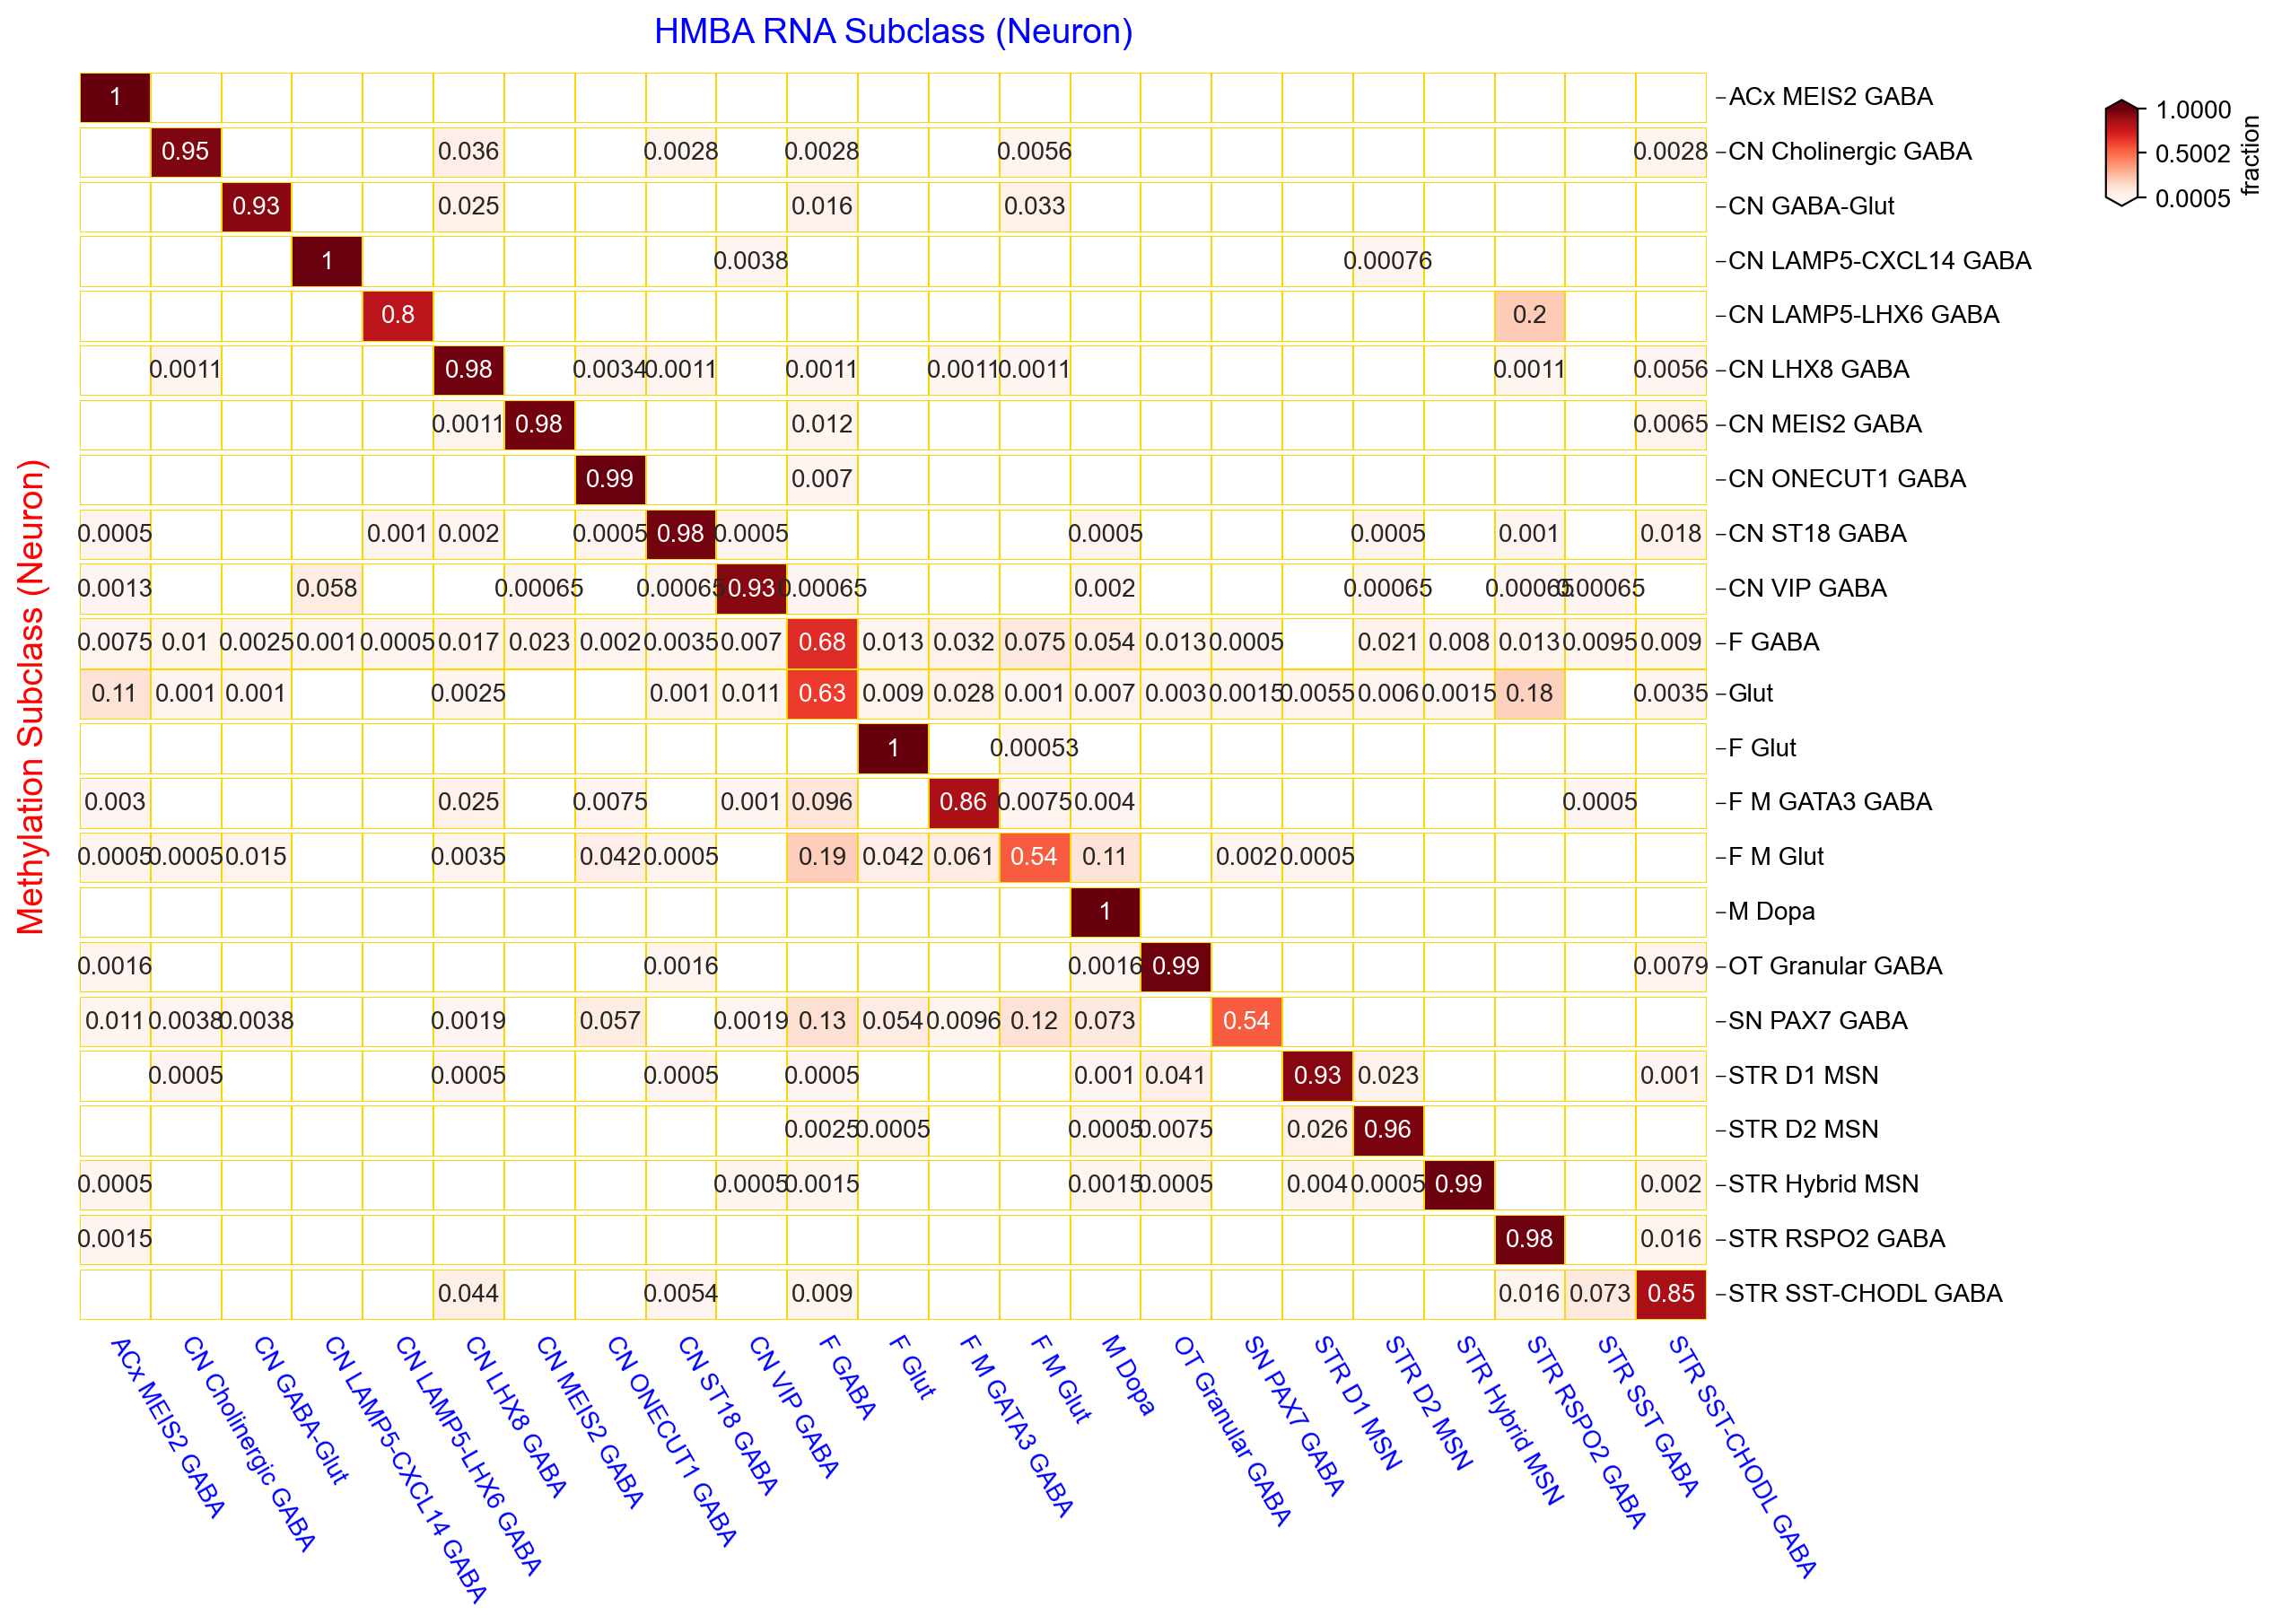

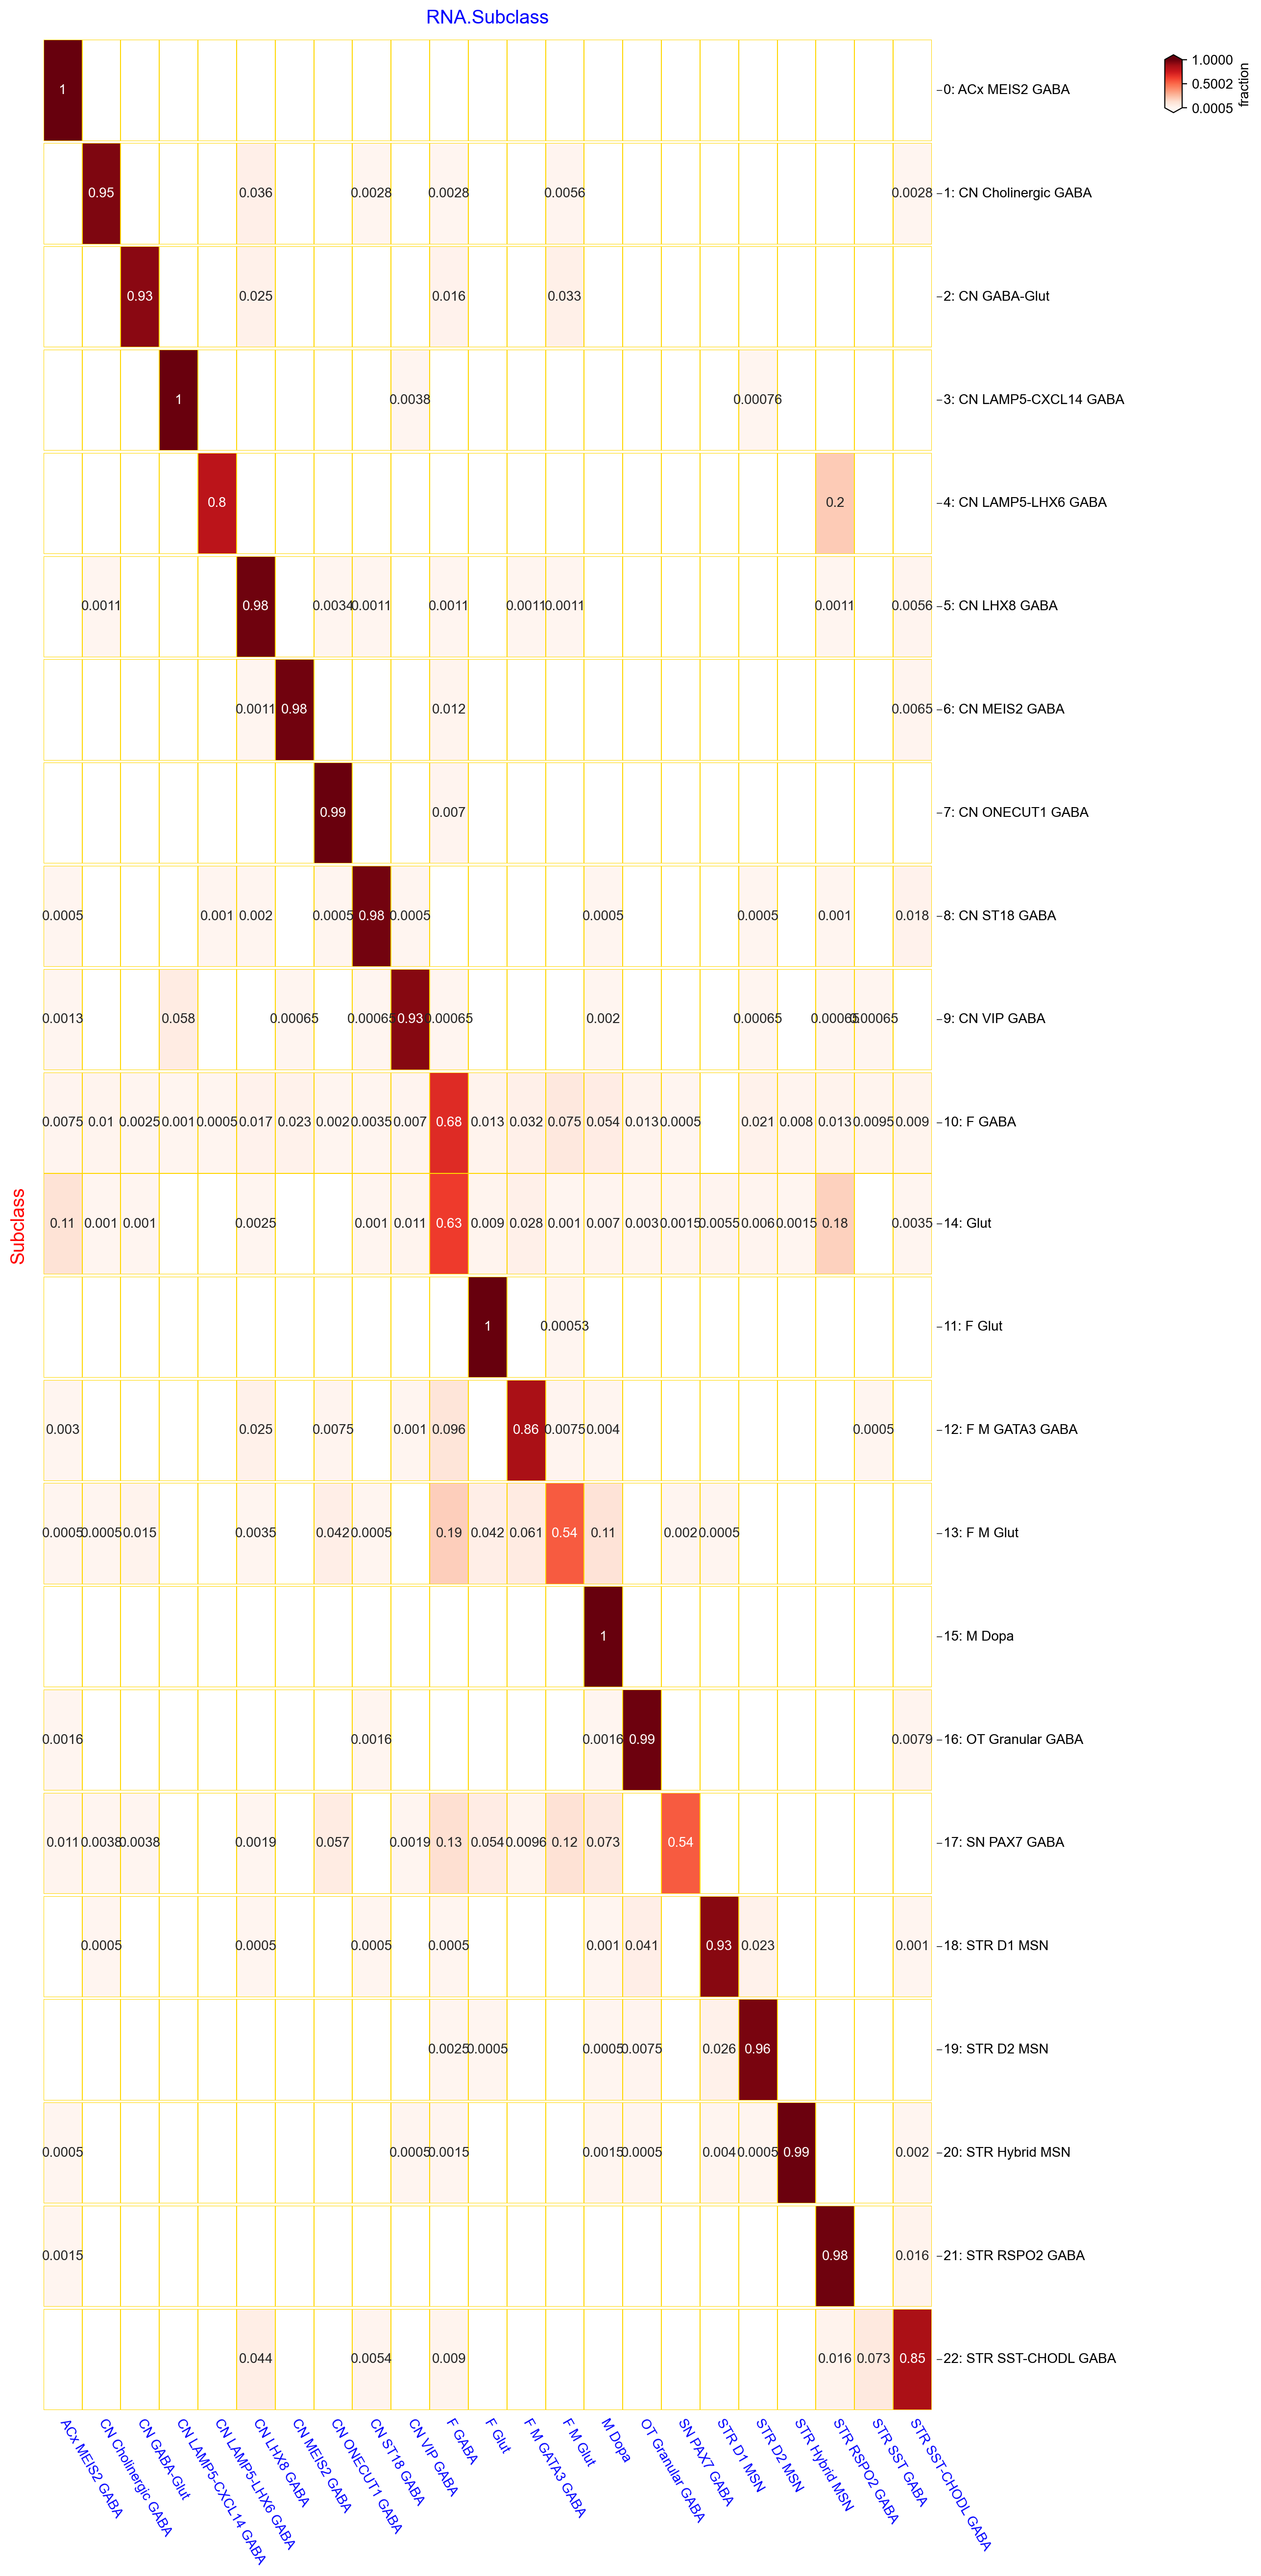

In [17]:
from PyComplexHeatmap import *
row_ha=HeatmapAnnotation(
    label=anno_label(df_rows[mc_cell_type],colors='black',relpos=(0,0.5)),
    axis=0,orientation='right',
)

plt.figure(figsize=(12,8))
ClusterMapPlotter(
    data.loc[df_rows.index.tolist()],row_cluster=False,col_cluster=False,cmap='Reds',
    right_annotation=row_ha,row_split=df_rows['GROUP'],row_split_gap=0.5,
    row_split_order=df_rows['GROUP'].unique().tolist(),
    show_rownames=False,show_colnames=True,yticklabels=True,xticklabels=True,
    xticklabels_kws=dict(labelrotation=-60,labelcolor='blue',labelsize=10),
    yticklabels_kws=dict(labelcolor='red',labelsize=10),
    annot=True,fmt='.2g',linewidth=0.05,linecolor='gold',linestyle='-:',
    label='fraction',legend_kws=dict(extend='both',extendfrac=0.1),
    xlabel="HMBA RNA Subclass (Neuron)",ylabel="Methylation Subclass (Neuron)",
    xlabel_kws=dict(color='blue',fontsize=14,labelpad=5),xlabel_side='top',
    ylabel_kws=dict(color='red',fontsize=14,labelpad=5), #increace labelpad manually using labelpad (points)
    # xlabel_bbox_kws=dict(facecolor='green'),
    # ylabel_bbox_kws=dict(facecolor='chocolate',edgecolor='red'),|
    # standard_scale=0,
)
plt.savefig(f"figures/confusion_matrix.pdf",dpi=300,bbox_inches='tight') #
plt.show()